In [1]:
pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 21.9 MB/s eta 0:00:00


#DOGE-USD

##7:2:1


In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from pmdarima.arima import auto_arima

# Đọc dữ liệu từ file CSV
data = pd.read_csv('/content/DOGE-USD.csv')
# Chuyển đổi cột 'date' thành đối tượng datetime
data['Date'] = pd.to_datetime(data['Date'])
# Sắp xếp dữ liệu theo ngày
data = data.sort_values('Date')

In [3]:
# Chia dữ liệu thành tập huấn luyện, tập kiểm tra và tập xác thực
train_size = int(0.7 * len(data))
test_size = int(0.2 * len(data))
validate_size = len(data) - train_size - test_size

train_data = data[:train_size]
test_data = data[train_size:train_size+test_size]
validate_data = data[train_size+test_size:]

In [4]:
# Lấy cột 'date' và 'close' để vẽ biểu đồ
train_dates = train_data['Date'].values
train_prices = train_data['Close'].values

test_dates = test_data['Date'].values
test_prices = test_data['Close'].values

validate_dates = validate_data['Date'].values
validate_prices = validate_data['Close'].values

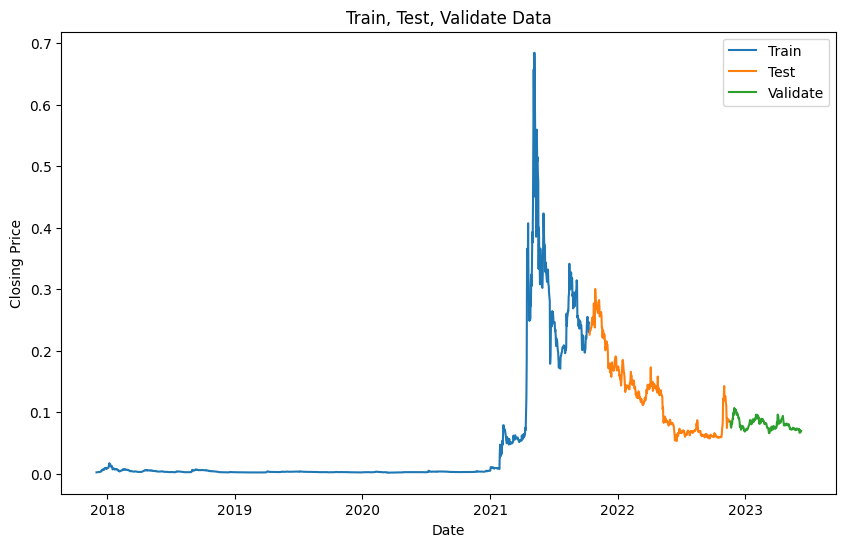

In [5]:
# Vẽ biểu đồ train, test và validate
plt.figure(figsize=(10, 6))
plt.plot(train_dates, train_prices, label='Train')
plt.plot(test_dates, test_prices, label='Test')
plt.plot(validate_dates, validate_prices, label='Validate')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Train, Test, Validate Data')
plt.legend()
plt.show()

In [6]:
# Huấn luyện mô hình Isolation Forest để phát hiện bất thường
model = IsolationForest(contamination=0.05)
model.fit(train_prices.reshape(-1, 1))

IsolationForest(contamination=0.05)

In [7]:
# Dự đoán bất thường trên dữ liệu huấn luyện
train_scores = model.decision_function(train_prices.reshape(-1, 1))

# Dự đoán bất thường trên dữ liệu kiểm tra
test_scores = model.decision_function(test_prices.reshape(-1, 1))

# Dự đoán bất thường trên dữ liệu xác thực
validate_scores = model.decision_function(validate_prices.reshape(-1, 1))

In [8]:
# Phát hiện bất thường trong dữ liệu huấn luyện
train_anomalies = np.where(model.predict(train_prices.reshape(-1, 1)) == -1)

# Phát hiện bất thường trong dữ liệu kiểm tra
test_anomalies = np.where(model.predict(test_prices.reshape(-1, 1)) == -1)

# Phát hiện bất thường trong dữ liệu xác thực
validate_anomalies = np.where(model.predict(validate_prices.reshape(-1, 1)) == -1)

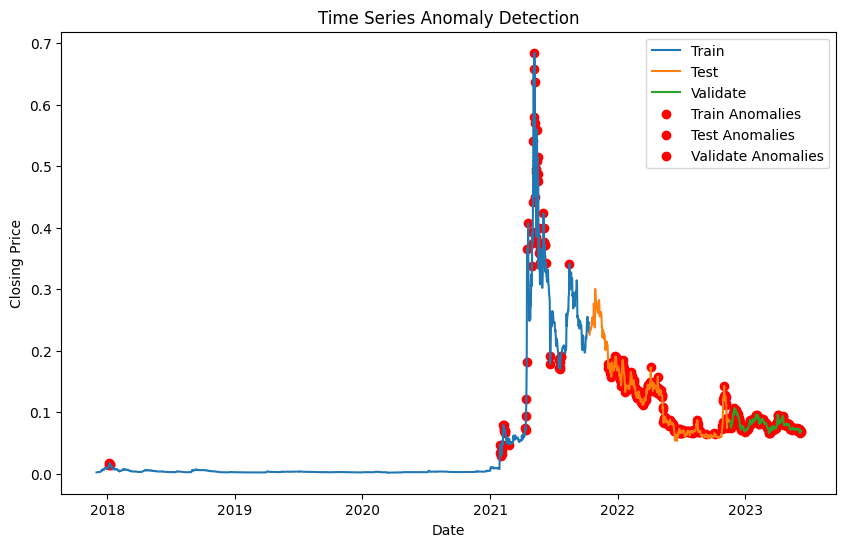

In [9]:
# Vẽ biểu đồ giá đóng cửa và đánh dấu các điểm bất thường
plt.figure(figsize=(10, 6))
plt.plot(train_dates, train_prices, label='Train')
plt.plot(test_dates, test_prices, label='Test')
plt.plot(validate_dates, validate_prices, label='Validate')
plt.scatter(train_dates[train_anomalies], train_prices[train_anomalies], color='red', label='Train Anomalies')
plt.scatter(test_dates[test_anomalies], test_prices[test_anomalies], color='red', label='Test Anomalies')
plt.scatter(validate_dates[validate_anomalies], validate_prices[validate_anomalies], color='red', label='Validate Anomalies')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Time Series Anomaly Detection')
plt.legend()
plt.show()

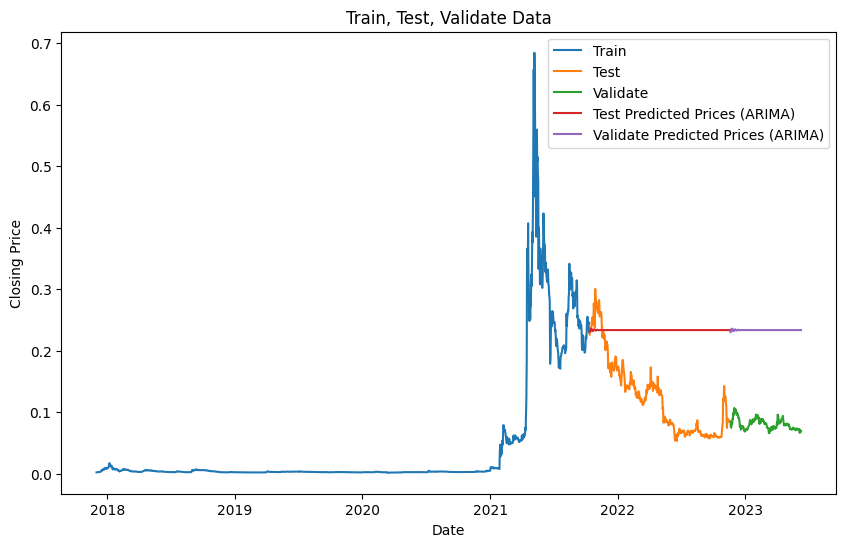

In [10]:
# Dự đoán giá của quá trình testing bằng thuật toán ARIMA
model_arima = auto_arima(train_prices, seasonal=False, trace=False)
test_predicted_prices_arima = model_arima.predict(n_periods=len(test_prices))

# Dự đoán giá của quá trình validation bằng thuật toán ARIMA
validate_predicted_prices_arima = model_arima.predict(n_periods=len(validate_prices))

# Vẽ biểu đồ train, test và validate
plt.figure(figsize=(10, 6))
plt.plot(train_dates, train_prices, label='Train')
plt.plot(test_dates, test_prices, label='Test')
plt.plot(validate_dates, validate_prices, label='Validate')
plt.plot(test_dates, test_predicted_prices_arima, label='Test Predicted Prices (ARIMA)')
plt.plot(validate_dates, validate_predicted_prices_arima, label='Validate Predicted Prices (ARIMA)')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Train, Test, Validate Data')
plt.legend()
plt.show()

In [11]:
# def calculate_metrics(actual, predicted):
#     mape = np.mean(np.abs((actual - predicted) / actual)) * 100
#     mae = np.mean(np.abs(actual - predicted))
#     rmse = np.sqrt(np.mean((actual - predicted)**2))
#     return mape, mae, rmse

# # Calculate metrics for the validation set
# validate_mape, validate_mae, validate_rmse = calculate_metrics(validate_prices, validate_scores)

# # Calculate metrics for the testing set
# test_mape, test_mae, test_rmse = calculate_metrics(test_prices, test_scores)

# print('---------VALIDATE----------')
# print("MAPE:", validate_mape)
# print("MAE:", validate_mae)
# print("RMSE:", validate_rmse)
# print('--------------------------')
# print('---------TEST----------')
# print("MAPE:", test_mape)
# print("MAE:", test_mae)
# print("RMSE:", test_rmse)
# print('-------------------')


In [12]:
def calculate_metrics(actual, predicted):
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    mae = np.mean(np.abs(actual - predicted))
    mse = np.mean((actual - predicted)**2)
    rmse = np.sqrt(mse)
    return mae, mse, rmse

# Calculate metrics for the validation set
validate_mape, validate_mae, validate_rmse = calculate_metrics(validate_prices, validate_scores)

# Calculate metrics for the testing set
test_mape, test_mae, test_rmse = calculate_metrics(test_prices, test_scores)

# In kết quả
print('---------VALIDATE----------')
print("MAPE:", round(validate_mape, 3))
print("MAE:", round(validate_mae, 3))
#print("MSE:", round(validate_mse, 3))
print("RMSE:", round(validate_rmse, 3))
print('--------------------------')
print('---------TEST----------')
print("MAPE:", round(test_mape, 3))
print("MAE:", round(test_mae, 3))
#print("MSE:", round(test_mse, 3))
print("RMSE:", round(test_rmse, 3))
print('-------------------')



---------VALIDATE----------
MAPE: 0.132
MAE: 0.018
RMSE: 0.134
--------------------------
---------TEST----------
MAPE: 0.15
MAE: 0.028
RMSE: 0.167
-------------------


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-8187.891, Time=1.86 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-8161.669, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-8182.490, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-8178.693, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-8163.460, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-8211.213, Time=1.11 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-8199.423, Time=0.64 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-8183.319, Time=0.70 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-8235.037, Time=1.49 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-8237.062, Time=1.53 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-8235.027, Time=1.61 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-8239.603, Time=2.70 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=-8270.552, Time=2.33 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-8269.645, Time=1.89 sec
 ARIMA(3,1,4)(0,0,0

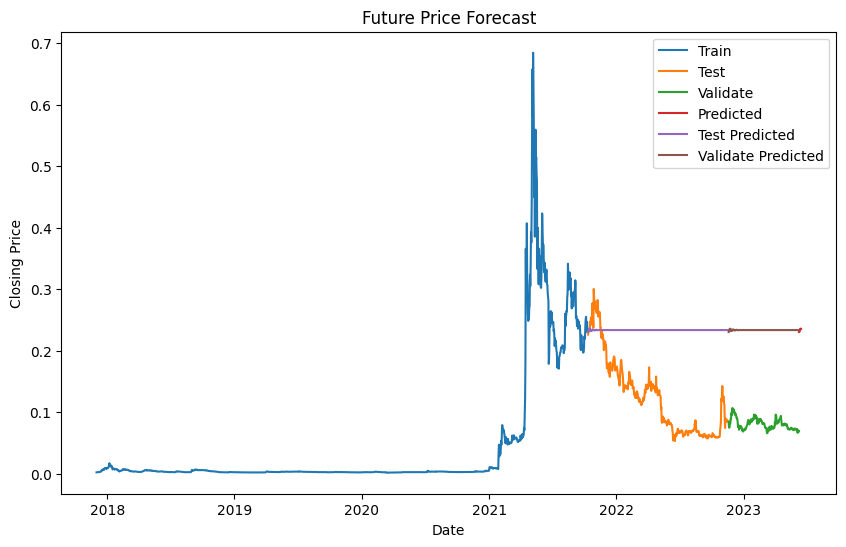

In [13]:
# Huấn luyện mô hình ARIMA trên tập huấn luyện
model = auto_arima(train_prices, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train_prices)

# Dự đoán 7 ngày tiếp theo
future_forecast = model.predict(n_periods=7)

# Tạo các ngày dự đoán cho 7 ngày tiếp theo
future_dates = pd.date_range(start=data['Date'].iloc[-1], periods=7)

# Vẽ biểu đồ dự đoán giá trong tương lai
plt.figure(figsize=(10, 6))
plt.plot(train_dates, train_prices, label='Train')
plt.plot(test_dates, test_prices, label='Test')
plt.plot(validate_dates, validate_prices, label='Validate')
plt.plot(future_dates, future_forecast, label='Predicted')
plt.plot(test_dates, test_predicted_prices_arima, label='Test Predicted')
plt.plot(validate_dates, validate_predicted_prices_arima, label='Validate Predicted')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Future Price Forecast')
plt.legend()
plt.show()

##5:3:2

In [14]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from pmdarima.arima import auto_arima

# Đọc dữ liệu từ file CSV
data = pd.read_csv('/content/DOGE-USD.csv')
# Chuyển đổi cột 'date' thành đối tượng datetime
data['Date'] = pd.to_datetime(data['Date'])
# Sắp xếp dữ liệu theo ngày
data = data.sort_values('Date')

In [15]:
# Chia dữ liệu thành tập huấn luyện, tập kiểm tra và tập xác thực
train_size = int(0.5 * len(data))
test_size = int(0.3 * len(data))
validate_size = len(data) - train_size - test_size

train_data = data[:train_size]
test_data = data[train_size:train_size+test_size]
validate_data = data[train_size+test_size:]

In [16]:
# Lấy cột 'date' và 'close' để vẽ biểu đồ
train_dates = train_data['Date'].values
train_prices = train_data['Close'].values

test_dates = test_data['Date'].values
test_prices = test_data['Close'].values

validate_dates = validate_data['Date'].values
validate_prices = validate_data['Close'].values

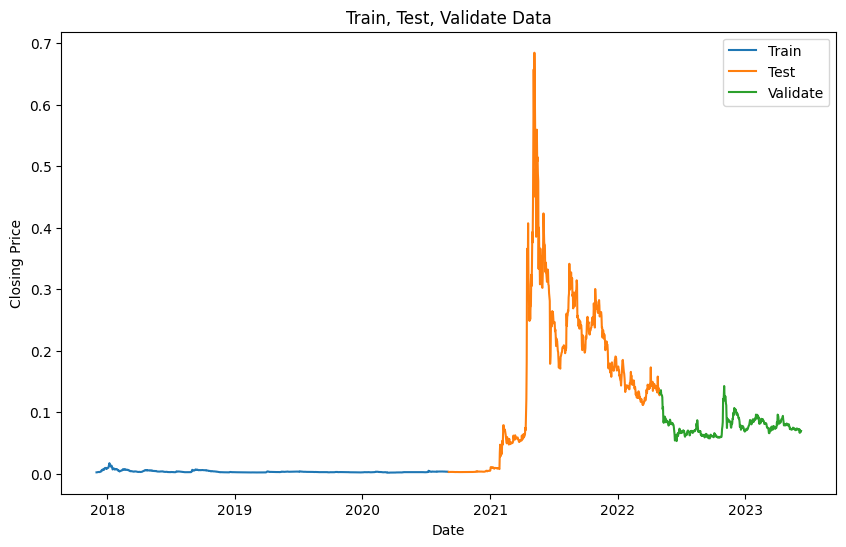

In [17]:
# Vẽ biểu đồ train, test và validate
plt.figure(figsize=(10, 6))
plt.plot(train_dates, train_prices, label='Train')
plt.plot(test_dates, test_prices, label='Test')
plt.plot(validate_dates, validate_prices, label='Validate')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Train, Test, Validate Data')
plt.legend()
plt.show()

In [18]:
# Huấn luyện mô hình Isolation Forest để phát hiện bất thường
model = IsolationForest(contamination=0.05)
model.fit(train_prices.reshape(-1, 1))

IsolationForest(contamination=0.05)

In [19]:
# Dự đoán bất thường trên dữ liệu huấn luyện
train_scores = model.decision_function(train_prices.reshape(-1, 1))

# Dự đoán bất thường trên dữ liệu kiểm tra
test_scores = model.decision_function(test_prices.reshape(-1, 1))

# Dự đoán bất thường trên dữ liệu xác thực
validate_scores = model.decision_function(validate_prices.reshape(-1, 1))

In [20]:
# Phát hiện bất thường trong dữ liệu huấn luyện
train_anomalies = np.where(model.predict(train_prices.reshape(-1, 1)) == -1)

# Phát hiện bất thường trong dữ liệu kiểm tra
test_anomalies = np.where(model.predict(test_prices.reshape(-1, 1)) == -1)

# Phát hiện bất thường trong dữ liệu xác thực
validate_anomalies = np.where(model.predict(validate_prices.reshape(-1, 1)) == -1)

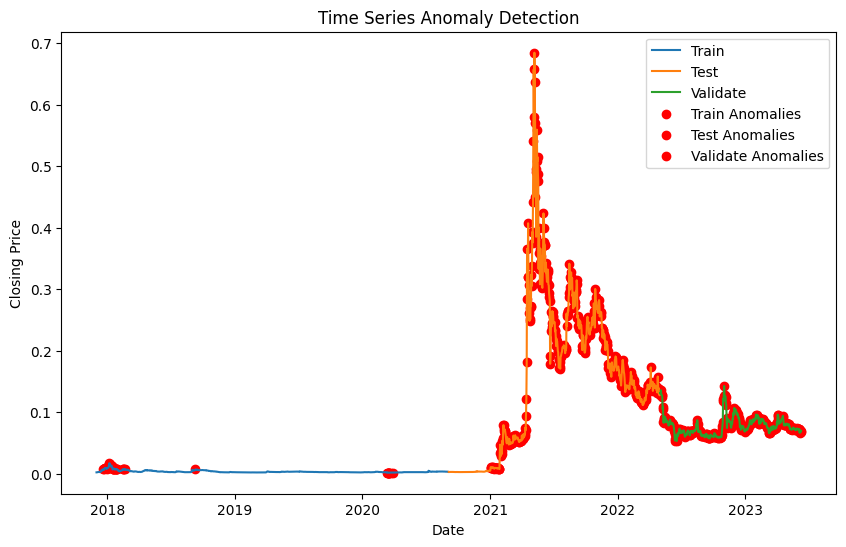

In [21]:
# Vẽ biểu đồ giá đóng cửa và đánh dấu các điểm bất thường
plt.figure(figsize=(10, 6))
plt.plot(train_dates, train_prices, label='Train')
plt.plot(test_dates, test_prices, label='Test')
plt.plot(validate_dates, validate_prices, label='Validate')
plt.scatter(train_dates[train_anomalies], train_prices[train_anomalies], color='red', label='Train Anomalies')
plt.scatter(test_dates[test_anomalies], test_prices[test_anomalies], color='red', label='Test Anomalies')
plt.scatter(validate_dates[validate_anomalies], validate_prices[validate_anomalies], color='red', label='Validate Anomalies')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Time Series Anomaly Detection')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


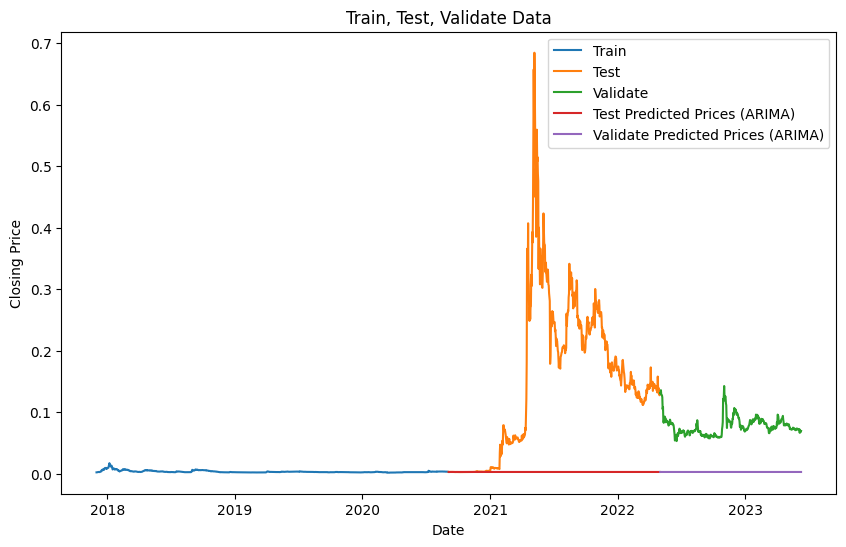

In [22]:
# Dự đoán giá của quá trình testing bằng thuật toán ARIMA
model_arima = auto_arima(train_prices, seasonal=False, trace=False)
test_predicted_prices_arima = model_arima.predict(n_periods=len(test_prices))

# Dự đoán giá của quá trình validation bằng thuật toán ARIMA
validate_predicted_prices_arima = model_arima.predict(n_periods=len(validate_prices))

# Vẽ biểu đồ train, test và validate
plt.figure(figsize=(10, 6))
plt.plot(train_dates, train_prices, label='Train')
plt.plot(test_dates, test_prices, label='Test')
plt.plot(validate_dates, validate_prices, label='Validate')
plt.plot(test_dates, test_predicted_prices_arima, label='Test Predicted Prices (ARIMA)')
plt.plot(validate_dates, validate_predicted_prices_arima, label='Validate Predicted Prices (ARIMA)')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Train, Test, Validate Data')
plt.legend()
plt.show()

In [23]:
# def calculate_metrics(actual, predicted):
#     mape = np.mean(np.abs((actual - predicted) / actual)) * 100
#     mae = np.mean(np.abs(actual - predicted))
#     rmse = np.sqrt(np.mean((actual - predicted)**2))
#     return mape, mae, rmse

# # Calculate metrics for the validation set
# validate_mape, validate_mae, validate_rmse = calculate_metrics(validate_prices, validate_scores)

# # Calculate metrics for the testing set
# test_mape, test_mae, test_rmse = calculate_metrics(test_prices, test_scores)

# print('---------VALIDATE----------')
# print("MAPE:", validate_mape)
# print("MAE:", validate_mae)
# print("RMSE:", validate_rmse)
# print('--------------------------')
# print('---------TEST----------')
# print("MAPE:", test_mape)
# print("MAE:", test_mae)
# print("RMSE:", test_rmse)
# print('-------------------')


In [24]:
def calculate_metrics(actual, predicted):
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    mae = np.mean(np.abs(actual - predicted))
    mse = np.mean((actual - predicted)**2)
    rmse = np.sqrt(mse)
    return mae, mse, rmse

# Calculate metrics for the validation set
validate_mape, validate_mae, validate_rmse = calculate_metrics(validate_prices, validate_scores)

# Calculate metrics for the testing set
test_mape, test_mae, test_rmse = calculate_metrics(test_prices, test_scores)

# In kết quả
print('---------VALIDATE----------')
print("MAPE:", round(validate_mape, 3))
print("MAE:", round(validate_mae, 3))
#print("MSE:", round(validate_mse, 3))
print("RMSE:", round(validate_rmse, 3))
print('--------------------------')
print('---------TEST----------')
print("MAPE:", round(test_mape, 3))
print("MAE:", round(test_mae, 3))
#print("MSE:", round(test_mse, 3))
print("RMSE:", round(test_rmse, 3))
print('-------------------')



---------VALIDATE----------
MAPE: 0.337
MAE: 0.114
RMSE: 0.338
--------------------------
---------TEST----------
MAPE: 0.383
MAE: 0.174
RMSE: 0.417
-------------------


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-13331.584, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-13325.688, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-13343.252, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-13343.617, Time=0.56 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-13327.683, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-13341.589, Time=0.47 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-13340.981, Time=0.31 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-13344.336, Time=0.38 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-13339.416, Time=1.09 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-13340.236, Time=1.09 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-13319.537, Time=0.72 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-13336.925, Time=1.68 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-13346.107, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-13342.983, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-13343.583, Time=0.31 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-13333.709, Time=0.18 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=-13341.419, Time=0.59 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-13345.617, Time=0.18 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-13342.243, Time=0.44 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-13321.541, Time=0.17 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,1,3)(0,0,0)[0]             : AIC=-13338.935, Time=0.62 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0]          
Total fit time: 9.918 seconds


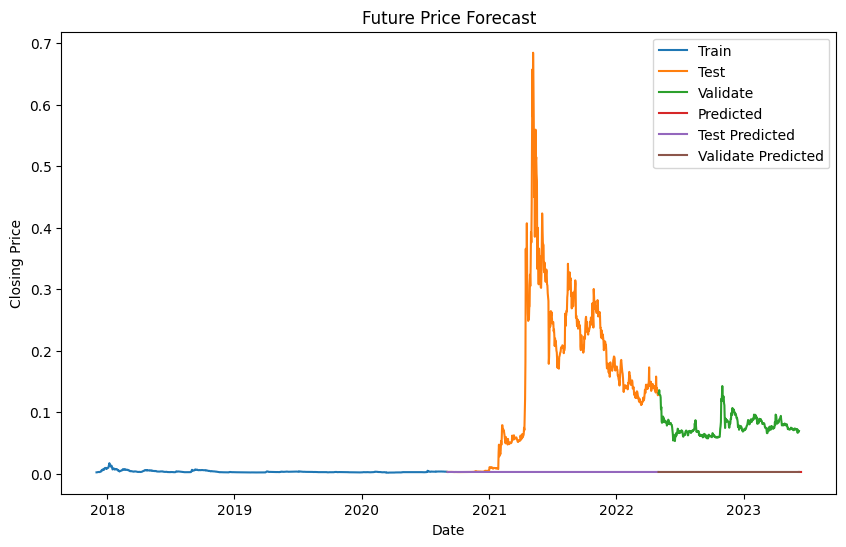

In [25]:
# Huấn luyện mô hình ARIMA trên tập huấn luyện
model = auto_arima(train_prices, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train_prices)

# Dự đoán 7 ngày tiếp theo
future_forecast = model.predict(n_periods=7)

# Tạo các ngày dự đoán cho 7 ngày tiếp theo
future_dates = pd.date_range(start=data['Date'].iloc[-1], periods=7)

# Vẽ biểu đồ dự đoán giá trong tương lai
plt.figure(figsize=(10, 6))
plt.plot(train_dates, train_prices, label='Train')
plt.plot(test_dates, test_prices, label='Test')
plt.plot(validate_dates, validate_prices, label='Validate')
plt.plot(future_dates, future_forecast, label='Predicted')
plt.plot(test_dates, test_predicted_prices_arima, label='Test Predicted')
plt.plot(validate_dates, validate_predicted_prices_arima, label='Validate Predicted')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Future Price Forecast')
plt.legend()
plt.show()

##6:2:2

In [26]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from pmdarima.arima import auto_arima

# Đọc dữ liệu từ file CSV
data = pd.read_csv('/content/DOGE-USD.csv')
# Chuyển đổi cột 'date' thành đối tượng datetime
data['Date'] = pd.to_datetime(data['Date'])
# Sắp xếp dữ liệu theo ngày
data = data.sort_values('Date')

In [27]:
# Chia dữ liệu thành tập huấn luyện, tập kiểm tra và tập xác thực
train_size = int(0.6 * len(data))
test_size = int(0.2 * len(data))
validate_size = len(data) - train_size - test_size

train_data = data[:train_size]
test_data = data[train_size:train_size+test_size]
validate_data = data[train_size+test_size:]

In [28]:
# Lấy cột 'date' và 'close' để vẽ biểu đồ
train_dates = train_data['Date'].values
train_prices = train_data['Close'].values

test_dates = test_data['Date'].values
test_prices = test_data['Close'].values

validate_dates = validate_data['Date'].values
validate_prices = validate_data['Close'].values

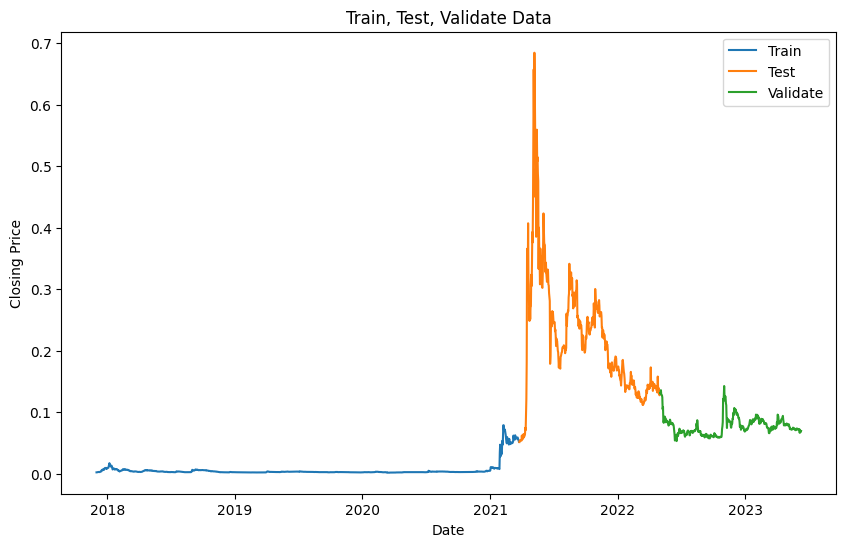

In [29]:
# Vẽ biểu đồ train, test và validate
plt.figure(figsize=(10, 6))
plt.plot(train_dates, train_prices, label='Train')
plt.plot(test_dates, test_prices, label='Test')
plt.plot(validate_dates, validate_prices, label='Validate')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Train, Test, Validate Data')
plt.legend()
plt.show()

In [30]:
# Huấn luyện mô hình Isolation Forest để phát hiện bất thường
model = IsolationForest(contamination=0.05)
model.fit(train_prices.reshape(-1, 1))

IsolationForest(contamination=0.05)

In [31]:
# Dự đoán bất thường trên dữ liệu huấn luyện
train_scores = model.decision_function(train_prices.reshape(-1, 1))

# Dự đoán bất thường trên dữ liệu kiểm tra
test_scores = model.decision_function(test_prices.reshape(-1, 1))

# Dự đoán bất thường trên dữ liệu xác thực
validate_scores = model.decision_function(validate_prices.reshape(-1, 1))

In [32]:
# Phát hiện bất thường trong dữ liệu huấn luyện
train_anomalies = np.where(model.predict(train_prices.reshape(-1, 1)) == -1)

# Phát hiện bất thường trong dữ liệu kiểm tra
test_anomalies = np.where(model.predict(test_prices.reshape(-1, 1)) == -1)

# Phát hiện bất thường trong dữ liệu xác thực
validate_anomalies = np.where(model.predict(validate_prices.reshape(-1, 1)) == -1)

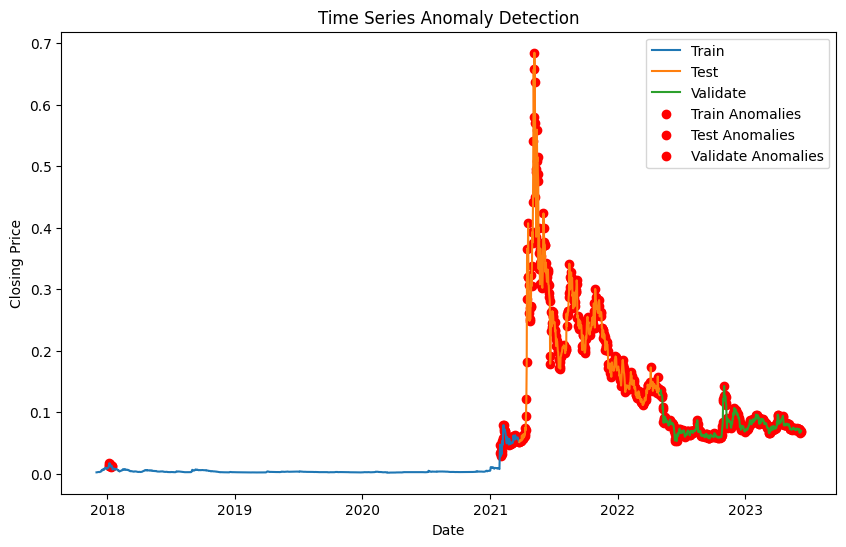

In [33]:
# Vẽ biểu đồ giá đóng cửa và đánh dấu các điểm bất thường
plt.figure(figsize=(10, 6))
plt.plot(train_dates, train_prices, label='Train')
plt.plot(test_dates, test_prices, label='Test')
plt.plot(validate_dates, validate_prices, label='Validate')
plt.scatter(train_dates[train_anomalies], train_prices[train_anomalies], color='red', label='Train Anomalies')
plt.scatter(test_dates[test_anomalies], test_prices[test_anomalies], color='red', label='Test Anomalies')
plt.scatter(validate_dates[validate_anomalies], validate_prices[validate_anomalies], color='red', label='Validate Anomalies')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Time Series Anomaly Detection')
plt.legend()
plt.show()

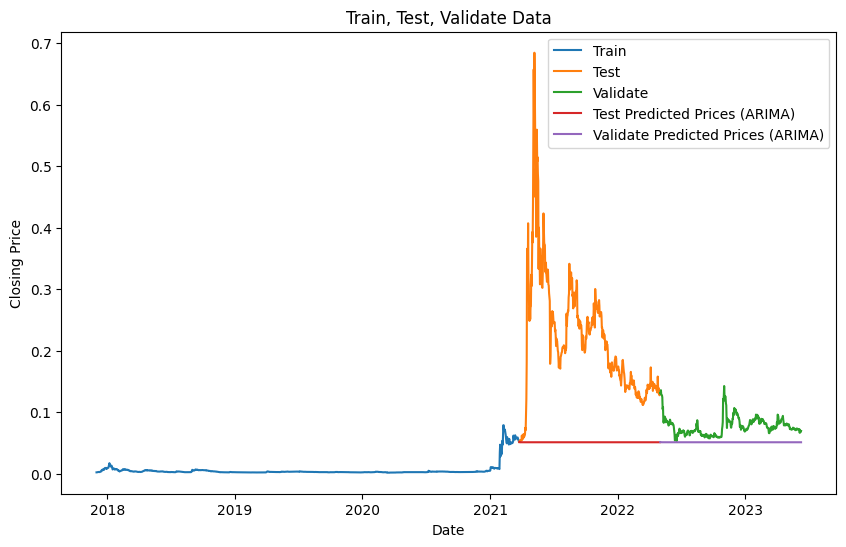

In [34]:
# Dự đoán giá của quá trình testing bằng thuật toán ARIMA
model_arima = auto_arima(train_prices, seasonal=False, trace=False)
test_predicted_prices_arima = model_arima.predict(n_periods=len(test_prices))

# Dự đoán giá của quá trình validation bằng thuật toán ARIMA
validate_predicted_prices_arima = model_arima.predict(n_periods=len(validate_prices))

# Vẽ biểu đồ train, test và validate
plt.figure(figsize=(10, 6))
plt.plot(train_dates, train_prices, label='Train')
plt.plot(test_dates, test_prices, label='Test')
plt.plot(validate_dates, validate_prices, label='Validate')
plt.plot(test_dates, test_predicted_prices_arima, label='Test Predicted Prices (ARIMA)')
plt.plot(validate_dates, validate_predicted_prices_arima, label='Validate Predicted Prices (ARIMA)')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Train, Test, Validate Data')
plt.legend()
plt.show()

In [35]:
# def calculate_metrics(actual, predicted):
#     mape = np.mean(np.abs((actual - predicted) / actual)) * 100
#     mae = np.mean(np.abs(actual - predicted))
#     rmse = np.sqrt(np.mean((actual - predicted)**2))
#     return mape, mae, rmse

# # Calculate metrics for the validation set
# validate_mape, validate_mae, validate_rmse = calculate_metrics(validate_prices, validate_scores)

# # Calculate metrics for the testing set
# test_mape, test_mae, test_rmse = calculate_metrics(test_prices, test_scores)

# print('---------VALIDATE----------')
# print("MAPE:", validate_mape)
# print("MAE:", validate_mae)
# print("RMSE:", validate_rmse)
# print('--------------------------')
# print('---------TEST----------')
# print("MAPE:", test_mape)
# print("MAE:", test_mae)
# print("RMSE:", test_rmse)
# print('-------------------')


In [36]:
def calculate_metrics(actual, predicted):
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    mae = np.mean(np.abs(actual - predicted))
    mse = np.mean((actual - predicted)**2)
    rmse = np.sqrt(mse)
    return mae, mse, rmse

# Calculate metrics for the validation set
validate_mape, validate_mae, validate_rmse = calculate_metrics(validate_prices, validate_scores)

# Calculate metrics for the testing set
test_mape, test_mae, test_rmse = calculate_metrics(test_prices, test_scores)

# In kết quả
print('---------VALIDATE----------')
print("MAPE:", round(validate_mape, 3))
print("MAE:", round(validate_mae, 3))
#print("MSE:", round(validate_mse, 3))
print("RMSE:", round(validate_rmse, 3))
print('--------------------------')
print('---------TEST----------')
print("MAPE:", round(test_mape, 3))
print("MAE:", round(test_mae, 3))
#print("MSE:", round(test_mse, 3))
print("RMSE:", round(test_rmse, 3))
print('-------------------')



---------VALIDATE----------
MAPE: 0.197
MAE: 0.041
RMSE: 0.203
--------------------------
---------TEST----------
MAPE: 0.36
MAE: 0.142
RMSE: 0.376
-------------------


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-12192.619, Time=1.60 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-12141.786, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-12143.452, Time=0.34 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-12142.508, Time=1.45 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-12142.986, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-12187.800, Time=0.96 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-11788.880, Time=0.90 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-12239.650, Time=1.66 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-12241.530, Time=0.86 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-12243.491, Time=1.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-12186.728, Time=0.42 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-12242.175, Time=1.41 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-12240.130, Time=1.60 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-12244.668, Time=0.38 sec
 ARIM

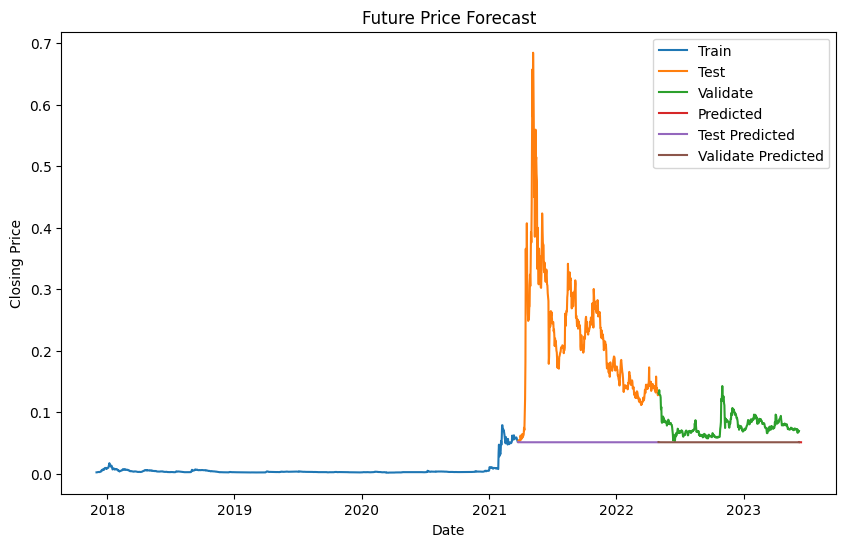

In [37]:
# Huấn luyện mô hình ARIMA trên tập huấn luyện
model = auto_arima(train_prices, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train_prices)

# Dự đoán 7 ngày tiếp theo
future_forecast = model.predict(n_periods=7)

# Tạo các ngày dự đoán cho 7 ngày tiếp theo
future_dates = pd.date_range(start=data['Date'].iloc[-1], periods=7)

# Vẽ biểu đồ dự đoán giá trong tương lai
plt.figure(figsize=(10, 6))
plt.plot(train_dates, train_prices, label='Train')
plt.plot(test_dates, test_prices, label='Test')
plt.plot(validate_dates, validate_prices, label='Validate')
plt.plot(future_dates, future_forecast, label='Predicted')
plt.plot(test_dates, test_predicted_prices_arima, label='Test Predicted')
plt.plot(validate_dates, validate_predicted_prices_arima, label='Validate Predicted')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Future Price Forecast')
plt.legend()
plt.show()

#TRX-USD

##7:2:1

In [38]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from pmdarima.arima import auto_arima

# Đọc dữ liệu từ file CSV
data = pd.read_csv('/content/TRX-USD.csv')
# Chuyển đổi cột 'date' thành đối tượng datetime
data['Date'] = pd.to_datetime(data['Date'])
# Sắp xếp dữ liệu theo ngày
data = data.sort_values('Date')

In [39]:
# Chia dữ liệu thành tập huấn luyện, tập kiểm tra và tập xác thực
train_size = int(0.7 * len(data))
test_size = int(0.2 * len(data))
validate_size = len(data) - train_size - test_size

train_data = data[:train_size]
test_data = data[train_size:train_size+test_size]
validate_data = data[train_size+test_size:]

In [40]:
# Lấy cột 'date' và 'close' để vẽ biểu đồ
train_dates = train_data['Date'].values
train_prices = train_data['Close'].values

test_dates = test_data['Date'].values
test_prices = test_data['Close'].values

validate_dates = validate_data['Date'].values
validate_prices = validate_data['Close'].values

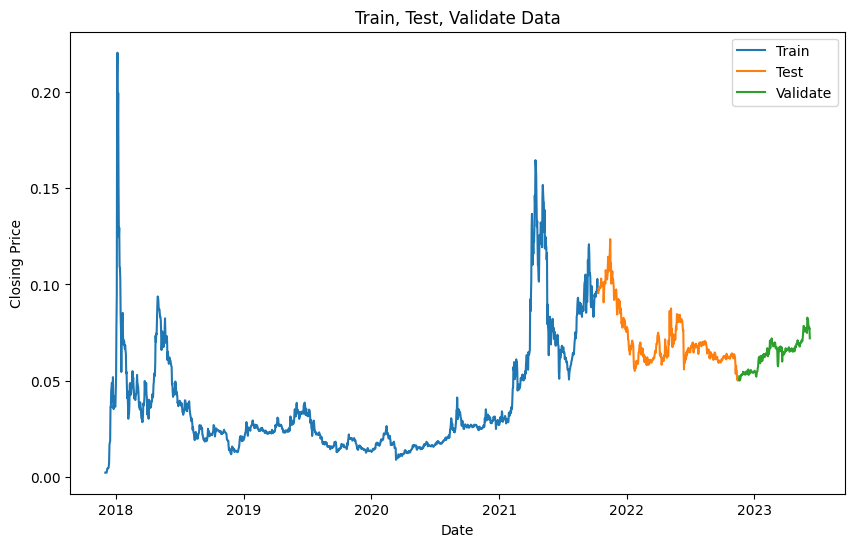

In [41]:
# Vẽ biểu đồ train, test và validate
plt.figure(figsize=(10, 6))
plt.plot(train_dates, train_prices, label='Train')
plt.plot(test_dates, test_prices, label='Test')
plt.plot(validate_dates, validate_prices, label='Validate')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Train, Test, Validate Data')
plt.legend()
plt.show()

In [42]:
# Huấn luyện mô hình Isolation Forest để phát hiện bất thường
model = IsolationForest(contamination=0.05)
model.fit(train_prices.reshape(-1, 1))

IsolationForest(contamination=0.05)

In [43]:
# Dự đoán bất thường trên dữ liệu huấn luyện
train_scores = model.decision_function(train_prices.reshape(-1, 1))

# Dự đoán bất thường trên dữ liệu kiểm tra
test_scores = model.decision_function(test_prices.reshape(-1, 1))

# Dự đoán bất thường trên dữ liệu xác thực
validate_scores = model.decision_function(validate_prices.reshape(-1, 1))

In [44]:
# Phát hiện bất thường trong dữ liệu huấn luyện
train_anomalies = np.where(model.predict(train_prices.reshape(-1, 1)) == -1)

# Phát hiện bất thường trong dữ liệu kiểm tra
test_anomalies = np.where(model.predict(test_prices.reshape(-1, 1)) == -1)

# Phát hiện bất thường trong dữ liệu xác thực
validate_anomalies = np.where(model.predict(validate_prices.reshape(-1, 1)) == -1)

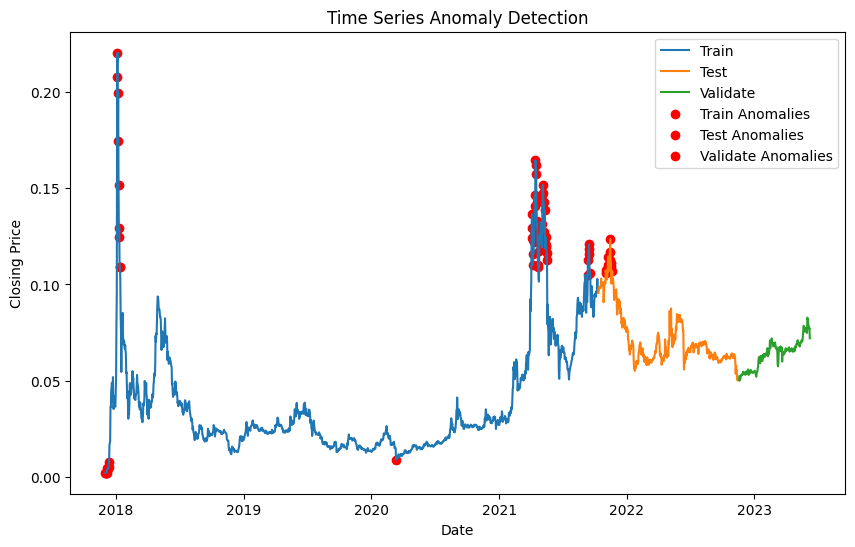

In [45]:
# Vẽ biểu đồ giá đóng cửa và đánh dấu các điểm bất thường
plt.figure(figsize=(10, 6))
plt.plot(train_dates, train_prices, label='Train')
plt.plot(test_dates, test_prices, label='Test')
plt.plot(validate_dates, validate_prices, label='Validate')
plt.scatter(train_dates[train_anomalies], train_prices[train_anomalies], color='red', label='Train Anomalies')
plt.scatter(test_dates[test_anomalies], test_prices[test_anomalies], color='red', label='Test Anomalies')
plt.scatter(validate_dates[validate_anomalies], validate_prices[validate_anomalies], color='red', label='Validate Anomalies')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Time Series Anomaly Detection')
plt.legend()
plt.show()

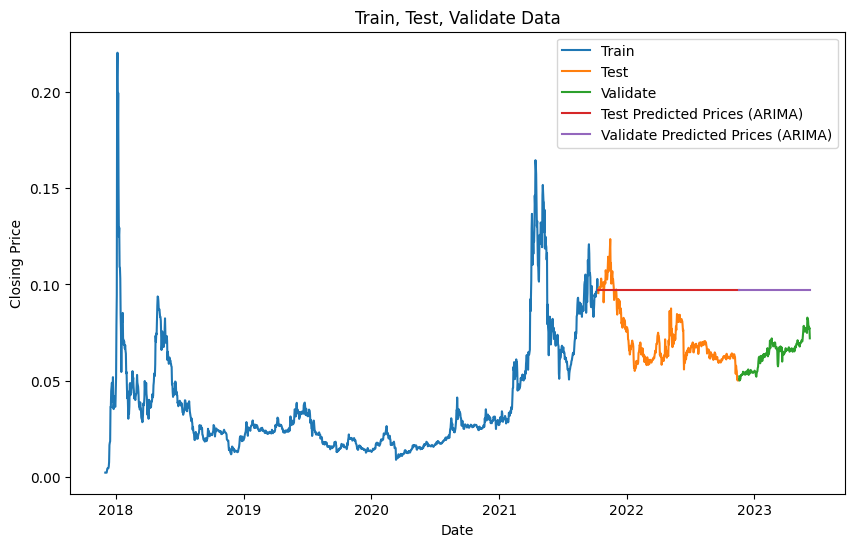

In [46]:
# Dự đoán giá của quá trình testing bằng thuật toán ARIMA
model_arima = auto_arima(train_prices, seasonal=False, trace=False)
test_predicted_prices_arima = model_arima.predict(n_periods=len(test_prices))

# Dự đoán giá của quá trình validation bằng thuật toán ARIMA
validate_predicted_prices_arima = model_arima.predict(n_periods=len(validate_prices))

# Vẽ biểu đồ train, test và validate
plt.figure(figsize=(10, 6))
plt.plot(train_dates, train_prices, label='Train')
plt.plot(test_dates, test_prices, label='Test')
plt.plot(validate_dates, validate_prices, label='Validate')
plt.plot(test_dates, test_predicted_prices_arima, label='Test Predicted Prices (ARIMA)')
plt.plot(validate_dates, validate_predicted_prices_arima, label='Validate Predicted Prices (ARIMA)')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Train, Test, Validate Data')
plt.legend()
plt.show()

In [47]:
# def calculate_metrics(actual, predicted):
#     mape = np.mean(np.abs((actual - predicted) / actual)) * 100
#     mae = np.mean(np.abs(actual - predicted))
#     rmse = np.sqrt(np.mean((actual - predicted)**2))
#     return mape, mae, rmse

# # Calculate metrics for the validation set
# validate_mape, validate_mae, validate_rmse = calculate_metrics(validate_prices, validate_scores)

# # Calculate metrics for the testing set
# test_mape, test_mae, test_rmse = calculate_metrics(test_prices, test_scores)

# print('---------VALIDATE----------')
# print("MAPE:", validate_mape)
# print("MAE:", validate_mae)
# print("RMSE:", validate_rmse)
# print('--------------------------')
# print('---------TEST----------')
# print("MAPE:", test_mape)
# print("MAE:", test_mae)
# print("RMSE:", test_rmse)
# print('-------------------')


In [48]:
def calculate_metrics(actual, predicted):
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    mae = np.mean(np.abs(actual - predicted))
    mse = np.mean((actual - predicted)**2)
    rmse = np.sqrt(mse)
    return mae, mse, rmse

# Calculate metrics for the validation set
validate_mape, validate_mae, validate_rmse = calculate_metrics(validate_prices, validate_scores)

# Calculate metrics for the testing set
test_mape, test_mae, test_rmse = calculate_metrics(test_prices, test_scores)

# In kết quả
print('---------VALIDATE----------')
print("MAPE:", round(validate_mape, 3))
print("MAE:", round(validate_mae, 3))
#print("MSE:", round(validate_mse, 3))
print("RMSE:", round(validate_rmse, 3))
print('--------------------------')
print('---------TEST----------')
print("MAPE:", round(test_mape, 3))
print("MAE:", round(test_mae, 3))
#print("MSE:", round(test_mse, 3))
print("RMSE:", round(test_rmse, 3))
print('-------------------')



---------VALIDATE----------
MAPE: 0.034
MAE: 0.001
RMSE: 0.036
--------------------------
---------TEST----------
MAPE: 0.039
MAE: 0.002
RMSE: 0.046
-------------------


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-10799.776, Time=1.47 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-10804.672, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-10803.055, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-10802.932, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-10806.438, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-10801.031, Time=0.52 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.601 seconds


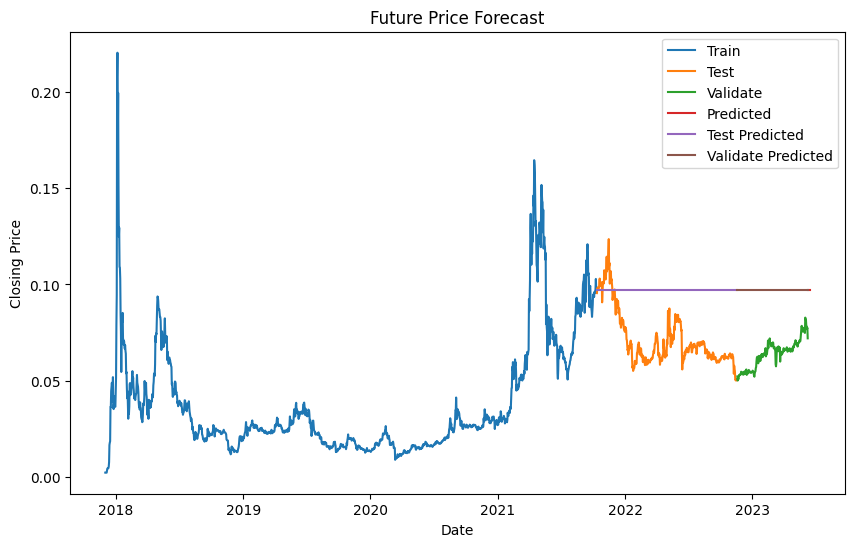

In [49]:
# Huấn luyện mô hình ARIMA trên tập huấn luyện
model = auto_arima(train_prices, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train_prices)

# Dự đoán 7 ngày tiếp theo
future_forecast = model.predict(n_periods=7)

# Tạo các ngày dự đoán cho 7 ngày tiếp theo
future_dates = pd.date_range(start=data['Date'].iloc[-1], periods=7)

# Vẽ biểu đồ dự đoán giá trong tương lai
plt.figure(figsize=(10, 6))
plt.plot(train_dates, train_prices, label='Train')
plt.plot(test_dates, test_prices, label='Test')
plt.plot(validate_dates, validate_prices, label='Validate')
plt.plot(future_dates, future_forecast, label='Predicted')
plt.plot(test_dates, test_predicted_prices_arima, label='Test Predicted')
plt.plot(validate_dates, validate_predicted_prices_arima, label='Validate Predicted')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Future Price Forecast')
plt.legend()
plt.show()

##5:3:2

In [50]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from pmdarima.arima import auto_arima

# Đọc dữ liệu từ file CSV
data = pd.read_csv('/content/TRX-USD.csv')
# Chuyển đổi cột 'date' thành đối tượng datetime
data['Date'] = pd.to_datetime(data['Date'])
# Sắp xếp dữ liệu theo ngày
data = data.sort_values('Date')

In [51]:
# Chia dữ liệu thành tập huấn luyện, tập kiểm tra và tập xác thực
train_size = int(0.5 * len(data))
test_size = int(0.3 * len(data))
validate_size = len(data) - train_size - test_size

train_data = data[:train_size]
test_data = data[train_size:train_size+test_size]
validate_data = data[train_size+test_size:]

In [52]:
# Lấy cột 'date' và 'close' để vẽ biểu đồ
train_dates = train_data['Date'].values
train_prices = train_data['Close'].values

test_dates = test_data['Date'].values
test_prices = test_data['Close'].values

validate_dates = validate_data['Date'].values
validate_prices = validate_data['Close'].values

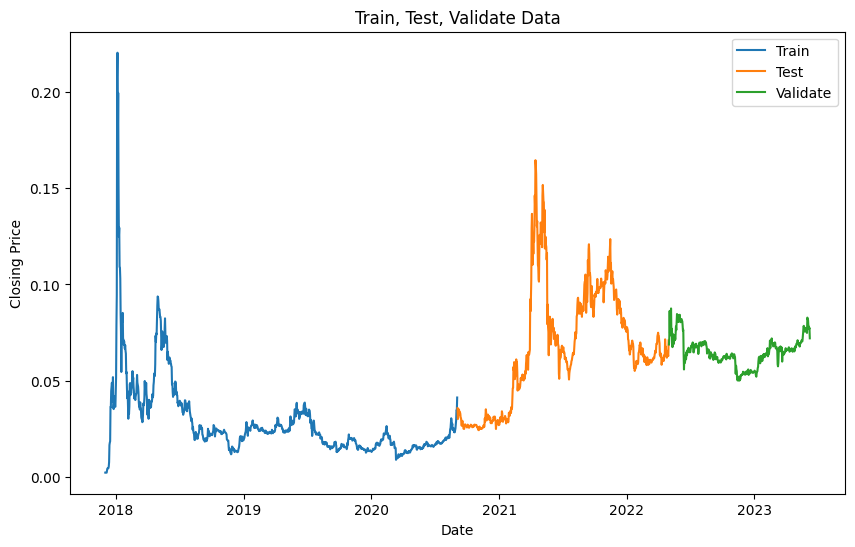

In [53]:
# Vẽ biểu đồ train, test và validate
plt.figure(figsize=(10, 6))
plt.plot(train_dates, train_prices, label='Train')
plt.plot(test_dates, test_prices, label='Test')
plt.plot(validate_dates, validate_prices, label='Validate')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Train, Test, Validate Data')
plt.legend()
plt.show()

In [54]:
# Huấn luyện mô hình Isolation Forest để phát hiện bất thường
model = IsolationForest(contamination=0.05)
model.fit(train_prices.reshape(-1, 1))

IsolationForest(contamination=0.05)

In [55]:
# Dự đoán bất thường trên dữ liệu huấn luyện
train_scores = model.decision_function(train_prices.reshape(-1, 1))

# Dự đoán bất thường trên dữ liệu kiểm tra
test_scores = model.decision_function(test_prices.reshape(-1, 1))

# Dự đoán bất thường trên dữ liệu xác thực
validate_scores = model.decision_function(validate_prices.reshape(-1, 1))

In [56]:
# Phát hiện bất thường trong dữ liệu huấn luyện
train_anomalies = np.where(model.predict(train_prices.reshape(-1, 1)) == -1)

# Phát hiện bất thường trong dữ liệu kiểm tra
test_anomalies = np.where(model.predict(test_prices.reshape(-1, 1)) == -1)

# Phát hiện bất thường trong dữ liệu xác thực
validate_anomalies = np.where(model.predict(validate_prices.reshape(-1, 1)) == -1)

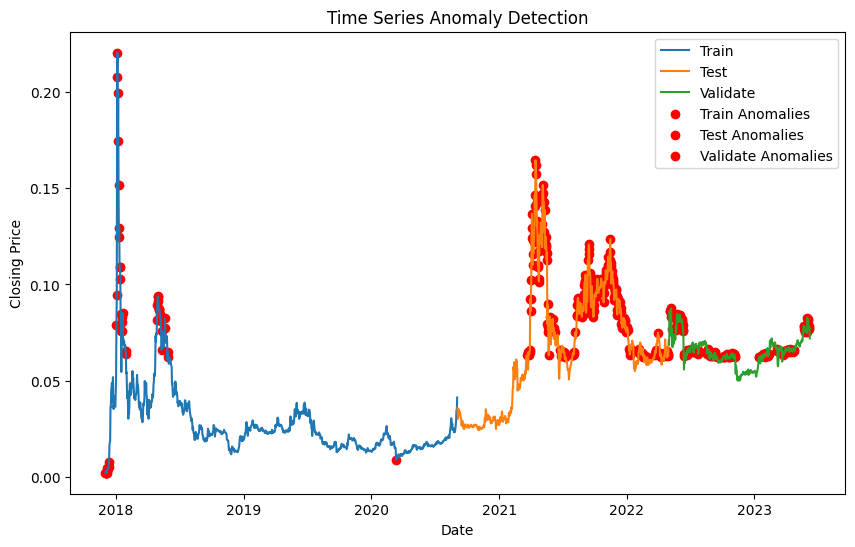

In [57]:
# Vẽ biểu đồ giá đóng cửa và đánh dấu các điểm bất thường
plt.figure(figsize=(10, 6))
plt.plot(train_dates, train_prices, label='Train')
plt.plot(test_dates, test_prices, label='Test')
plt.plot(validate_dates, validate_prices, label='Validate')
plt.scatter(train_dates[train_anomalies], train_prices[train_anomalies], color='red', label='Train Anomalies')
plt.scatter(test_dates[test_anomalies], test_prices[test_anomalies], color='red', label='Test Anomalies')
plt.scatter(validate_dates[validate_anomalies], validate_prices[validate_anomalies], color='red', label='Validate Anomalies')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Time Series Anomaly Detection')
plt.legend()
plt.show()

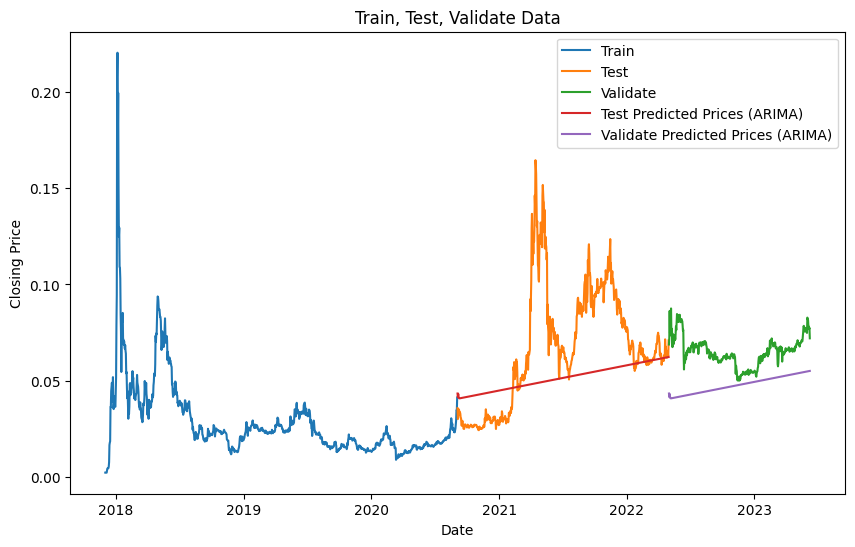

In [58]:
# Dự đoán giá của quá trình testing bằng thuật toán ARIMA
model_arima = auto_arima(train_prices, seasonal=False, trace=False)
test_predicted_prices_arima = model_arima.predict(n_periods=len(test_prices))

# Dự đoán giá của quá trình validation bằng thuật toán ARIMA
validate_predicted_prices_arima = model_arima.predict(n_periods=len(validate_prices))

# Vẽ biểu đồ train, test và validate
plt.figure(figsize=(10, 6))
plt.plot(train_dates, train_prices, label='Train')
plt.plot(test_dates, test_prices, label='Test')
plt.plot(validate_dates, validate_prices, label='Validate')
plt.plot(test_dates, test_predicted_prices_arima, label='Test Predicted Prices (ARIMA)')
plt.plot(validate_dates, validate_predicted_prices_arima, label='Validate Predicted Prices (ARIMA)')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Train, Test, Validate Data')
plt.legend()
plt.show()

In [59]:
# def calculate_metrics(actual, predicted):
#     mape = np.mean(np.abs((actual - predicted) / actual)) * 100
#     mae = np.mean(np.abs(actual - predicted))
#     rmse = np.sqrt(np.mean((actual - predicted)**2))
#     return mape, mae, rmse

# # Calculate metrics for the validation set
# validate_mape, validate_mae, validate_rmse = calculate_metrics(validate_prices, validate_scores)

# # Calculate metrics for the testing set
# test_mape, test_mae, test_rmse = calculate_metrics(test_prices, test_scores)

# print('---------VALIDATE----------')
# print("MAPE:", validate_mape)
# print("MAE:", validate_mae)
# print("RMSE:", validate_rmse)
# print('--------------------------')
# print('---------TEST----------')
# print("MAPE:", test_mape)
# print("MAE:", test_mae)
# print("RMSE:", test_rmse)
# print('-------------------')


In [60]:
def calculate_metrics(actual, predicted):
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    mae = np.mean(np.abs(actual - predicted))
    mse = np.mean((actual - predicted)**2)
    rmse = np.sqrt(mse)
    return mae, mse, rmse

# Calculate metrics for the validation set
validate_mape, validate_mae, validate_rmse = calculate_metrics(validate_prices, validate_scores)

# Calculate metrics for the testing set
test_mape, test_mae, test_rmse = calculate_metrics(test_prices, test_scores)

# In kết quả
print('---------VALIDATE----------')
print("MAPE:", round(validate_mape, 3))
print("MAE:", round(validate_mae, 3))
#print("MSE:", round(validate_mse, 3))
print("RMSE:", round(validate_rmse, 3))
print('--------------------------')
print('---------TEST----------')
print("MAPE:", round(test_mape, 3))
print("MAE:", round(test_mae, 3))
#print("MSE:", round(test_mse, 3))
print("RMSE:", round(test_rmse, 3))
print('-------------------')



---------VALIDATE----------
MAPE: 0.062
MAE: 0.004
RMSE: 0.065
--------------------------
---------TEST----------
MAPE: 0.127
MAE: 0.023
RMSE: 0.152
-------------------


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-7804.328, Time=1.37 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-7749.881, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-7753.469, Time=0.25 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-7753.165, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-7751.823, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-7808.144, Time=1.24 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-7747.564, Time=0.53 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-7745.880, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-7872.431, Time=0.89 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-7850.662, Time=1.12 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-7880.762, Time=1.66 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-7880.316, Time=2.55 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=-7886.439, Time=1.10 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-7888.373, Time=1.28 sec
 ARIMA(0,1,4)(0,0,0

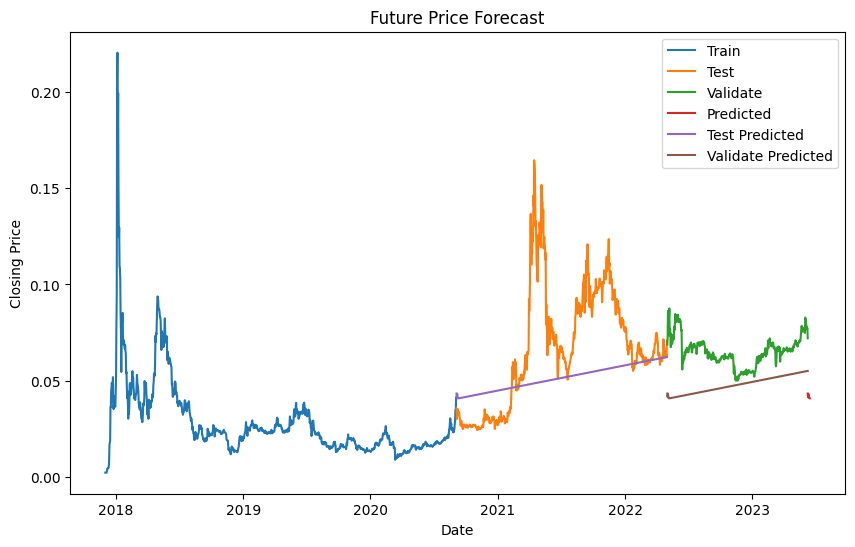

In [61]:
# Huấn luyện mô hình ARIMA trên tập huấn luyện
model = auto_arima(train_prices, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train_prices)

# Dự đoán 7 ngày tiếp theo
future_forecast = model.predict(n_periods=7)

# Tạo các ngày dự đoán cho 7 ngày tiếp theo
future_dates = pd.date_range(start=data['Date'].iloc[-1], periods=7)

# Vẽ biểu đồ dự đoán giá trong tương lai
plt.figure(figsize=(10, 6))
plt.plot(train_dates, train_prices, label='Train')
plt.plot(test_dates, test_prices, label='Test')
plt.plot(validate_dates, validate_prices, label='Validate')
plt.plot(future_dates, future_forecast, label='Predicted')
plt.plot(test_dates, test_predicted_prices_arima, label='Test Predicted')
plt.plot(validate_dates, validate_predicted_prices_arima, label='Validate Predicted')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Future Price Forecast')
plt.legend()
plt.show()

##6:2:2

In [62]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from pmdarima.arima import auto_arima

# Đọc dữ liệu từ file CSV
data = pd.read_csv('/content/TRX-USD.csv')
# Chuyển đổi cột 'date' thành đối tượng datetime
data['Date'] = pd.to_datetime(data['Date'])
# Sắp xếp dữ liệu theo ngày
data = data.sort_values('Date')

In [63]:
# Chia dữ liệu thành tập huấn luyện, tập kiểm tra và tập xác thực
train_size = int(0.6 * len(data))
test_size = int(0.2 * len(data))
validate_size = len(data) - train_size - test_size

train_data = data[:train_size]
test_data = data[train_size:train_size+test_size]
validate_data = data[train_size+test_size:]

In [64]:
# Lấy cột 'date' và 'close' để vẽ biểu đồ
train_dates = train_data['Date'].values
train_prices = train_data['Close'].values

test_dates = test_data['Date'].values
test_prices = test_data['Close'].values

validate_dates = validate_data['Date'].values
validate_prices = validate_data['Close'].values

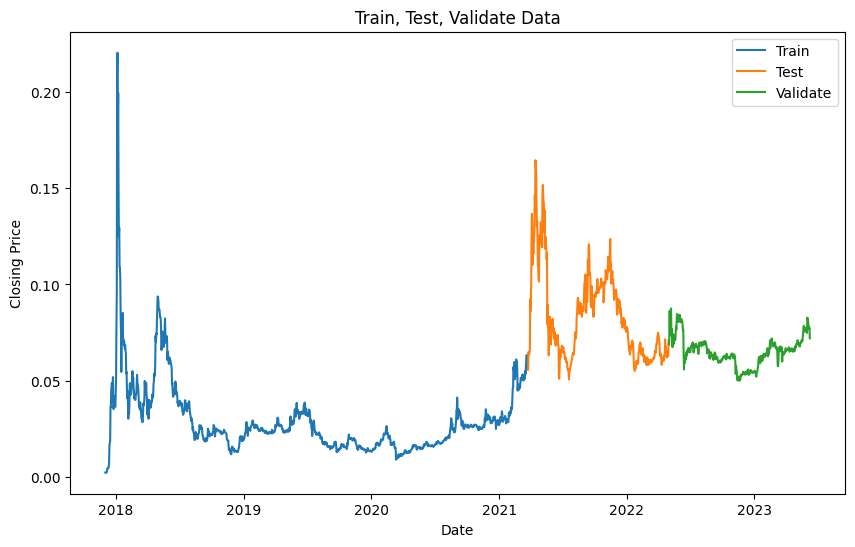

In [65]:
# Vẽ biểu đồ train, test và validate
plt.figure(figsize=(10, 6))
plt.plot(train_dates, train_prices, label='Train')
plt.plot(test_dates, test_prices, label='Test')
plt.plot(validate_dates, validate_prices, label='Validate')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Train, Test, Validate Data')
plt.legend()
plt.show()

In [66]:
# Huấn luyện mô hình Isolation Forest để phát hiện bất thường
model = IsolationForest(contamination=0.05)
model.fit(train_prices.reshape(-1, 1))

IsolationForest(contamination=0.05)

In [67]:
# Dự đoán bất thường trên dữ liệu huấn luyện
train_scores = model.decision_function(train_prices.reshape(-1, 1))

# Dự đoán bất thường trên dữ liệu kiểm tra
test_scores = model.decision_function(test_prices.reshape(-1, 1))

# Dự đoán bất thường trên dữ liệu xác thực
validate_scores = model.decision_function(validate_prices.reshape(-1, 1))

In [68]:
# Phát hiện bất thường trong dữ liệu huấn luyện
train_anomalies = np.where(model.predict(train_prices.reshape(-1, 1)) == -1)

# Phát hiện bất thường trong dữ liệu kiểm tra
test_anomalies = np.where(model.predict(test_prices.reshape(-1, 1)) == -1)

# Phát hiện bất thường trong dữ liệu xác thực
validate_anomalies = np.where(model.predict(validate_prices.reshape(-1, 1)) == -1)

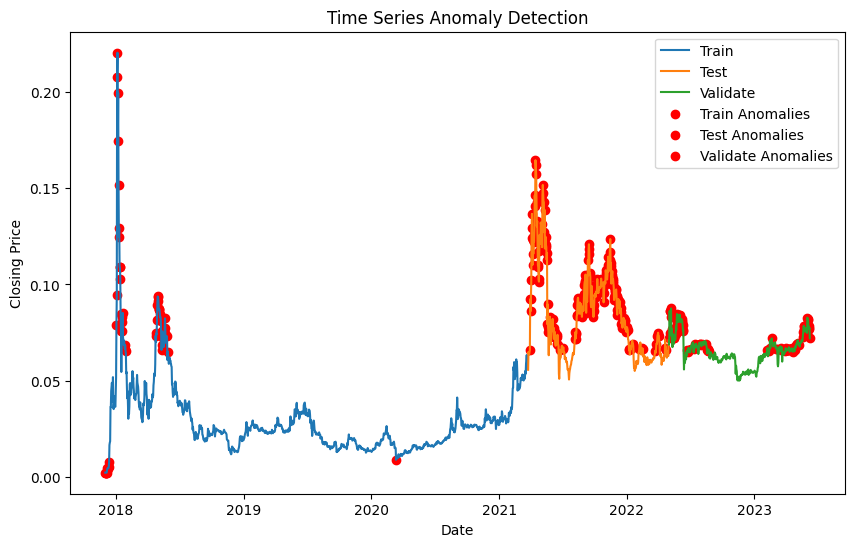

In [69]:
# Vẽ biểu đồ giá đóng cửa và đánh dấu các điểm bất thường
plt.figure(figsize=(10, 6))
plt.plot(train_dates, train_prices, label='Train')
plt.plot(test_dates, test_prices, label='Test')
plt.plot(validate_dates, validate_prices, label='Validate')
plt.scatter(train_dates[train_anomalies], train_prices[train_anomalies], color='red', label='Train Anomalies')
plt.scatter(test_dates[test_anomalies], test_prices[test_anomalies], color='red', label='Test Anomalies')
plt.scatter(validate_dates[validate_anomalies], validate_prices[validate_anomalies], color='red', label='Validate Anomalies')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Time Series Anomaly Detection')
plt.legend()
plt.show()

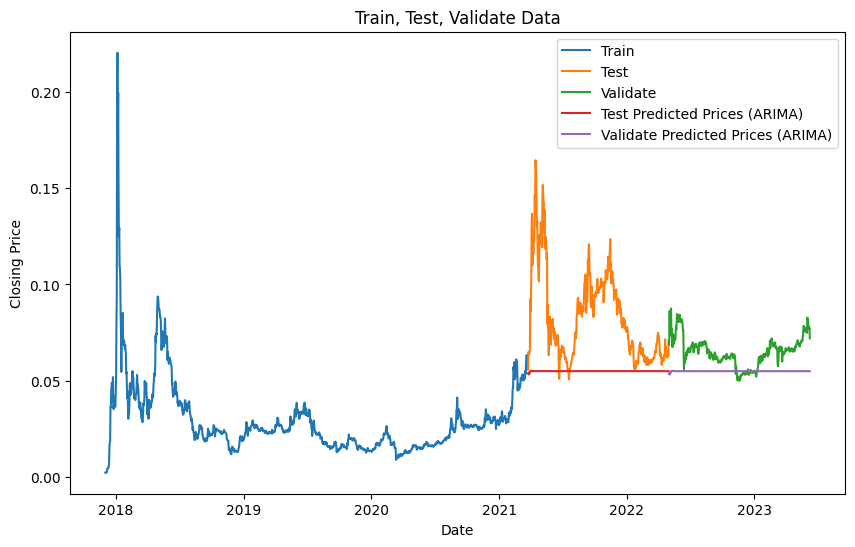

In [70]:
# Dự đoán giá của quá trình testing bằng thuật toán ARIMA
model_arima = auto_arima(train_prices, seasonal=False, trace=False)
test_predicted_prices_arima = model_arima.predict(n_periods=len(test_prices))

# Dự đoán giá của quá trình validation bằng thuật toán ARIMA
validate_predicted_prices_arima = model_arima.predict(n_periods=len(validate_prices))

# Vẽ biểu đồ train, test và validate
plt.figure(figsize=(10, 6))
plt.plot(train_dates, train_prices, label='Train')
plt.plot(test_dates, test_prices, label='Test')
plt.plot(validate_dates, validate_prices, label='Validate')
plt.plot(test_dates, test_predicted_prices_arima, label='Test Predicted Prices (ARIMA)')
plt.plot(validate_dates, validate_predicted_prices_arima, label='Validate Predicted Prices (ARIMA)')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Train, Test, Validate Data')
plt.legend()
plt.show()

In [71]:
# def calculate_metrics(actual, predicted):
#     mape = np.mean(np.abs((actual - predicted) / actual)) * 100
#     mae = np.mean(np.abs(actual - predicted))
#     rmse = np.sqrt(np.mean((actual - predicted)**2))
#     return mape, mae, rmse

# # Calculate metrics for the validation set
# validate_mape, validate_mae, validate_rmse = calculate_metrics(validate_prices, validate_scores)

# # Calculate metrics for the testing set
# test_mape, test_mae, test_rmse = calculate_metrics(test_prices, test_scores)

# print('---------VALIDATE----------')
# print("MAPE:", validate_mape)
# print("MAE:", validate_mae)
# print("RMSE:", validate_rmse)
# print('--------------------------')
# print('---------TEST----------')
# print("MAPE:", test_mape)
# print("MAE:", test_mae)
# print("RMSE:", test_rmse)
# print('-------------------')


In [72]:
def calculate_metrics(actual, predicted):
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    mae = np.mean(np.abs(actual - predicted))
    mse = np.mean((actual - predicted)**2)
    rmse = np.sqrt(mse)
    return mae, mse, rmse

# Calculate metrics for the validation set
validate_mape, validate_mae, validate_rmse = calculate_metrics(validate_prices, validate_scores)

# Calculate metrics for the testing set
test_mape, test_mae, test_rmse = calculate_metrics(test_prices, test_scores)

# In kết quả
print('---------VALIDATE----------')
print("MAPE:", round(validate_mape, 3))
print("MAE:", round(validate_mae, 3))
#print("MSE:", round(validate_mse, 3))
print("RMSE:", round(validate_rmse, 3))
print('--------------------------')
print('---------TEST----------')
print("MAPE:", round(test_mape, 3))
print("MAE:", round(test_mae, 3))
#print("MSE:", round(test_mse, 3))
print("RMSE:", round(test_rmse, 3))
print('-------------------')



---------VALIDATE----------
MAPE: 0.058
MAE: 0.005
RMSE: 0.067
--------------------------
---------TEST----------
MAPE: 0.14
MAE: 0.029
RMSE: 0.171
-------------------


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-9544.714, Time=1.82 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-9487.923, Time=0.26 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-9491.907, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-9491.566, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-9489.817, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-9548.913, Time=1.72 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-9485.569, Time=0.36 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-9483.921, Time=0.26 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-9618.085, Time=0.65 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-9597.912, Time=0.93 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-9620.682, Time=0.50 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-9620.918, Time=1.02 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-9621.309, Time=1.41 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-9541.259, Time=0.45 sec
 ARIMA(4,1,2)(0,0,0

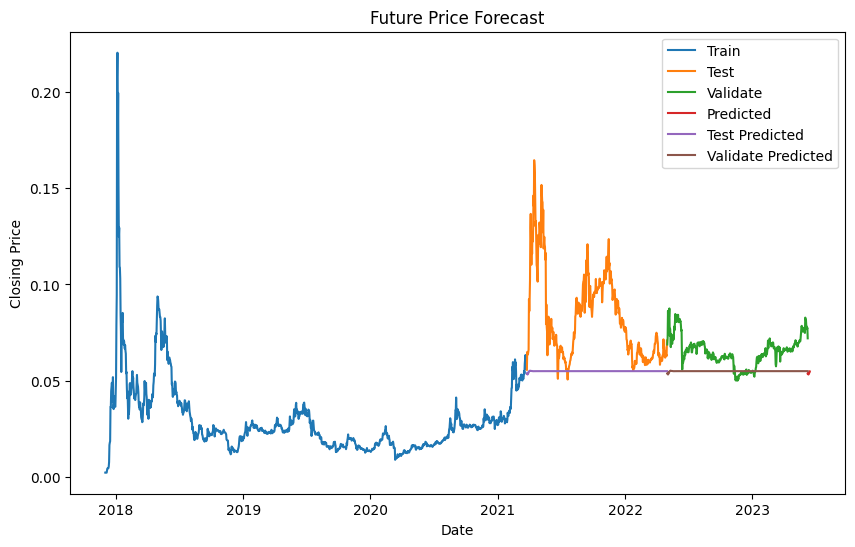

In [73]:
# Huấn luyện mô hình ARIMA trên tập huấn luyện
model = auto_arima(train_prices, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train_prices)

# Dự đoán 7 ngày tiếp theo
future_forecast = model.predict(n_periods=7)

# Tạo các ngày dự đoán cho 7 ngày tiếp theo
future_dates = pd.date_range(start=data['Date'].iloc[-1], periods=7)

# Vẽ biểu đồ dự đoán giá trong tương lai
plt.figure(figsize=(10, 6))
plt.plot(train_dates, train_prices, label='Train')
plt.plot(test_dates, test_prices, label='Test')
plt.plot(validate_dates, validate_prices, label='Validate')
plt.plot(future_dates, future_forecast, label='Predicted')
plt.plot(test_dates, test_predicted_prices_arima, label='Test Predicted')
plt.plot(validate_dates, validate_predicted_prices_arima, label='Validate Predicted')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Future Price Forecast')
plt.legend()
plt.show()

#XLM-USD

##7:2:1

In [74]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from pmdarima.arima import auto_arima

# Đọc dữ liệu từ file CSV
data = pd.read_csv('/content/XLM-USD.csv')
# Chuyển đổi cột 'date' thành đối tượng datetime
data['Date'] = pd.to_datetime(data['Date'])
# Sắp xếp dữ liệu theo ngày
data = data.sort_values('Date')

In [75]:
# Chia dữ liệu thành tập huấn luyện, tập kiểm tra và tập xác thực
train_size = int(0.7 * len(data))
test_size = int(0.2 * len(data))
validate_size = len(data) - train_size - test_size

train_data = data[:train_size]
test_data = data[train_size:train_size+test_size]
validate_data = data[train_size+test_size:]

In [76]:
# Lấy cột 'date' và 'close' để vẽ biểu đồ
train_dates = train_data['Date'].values
train_prices = train_data['Close'].values

test_dates = test_data['Date'].values
test_prices = test_data['Close'].values

validate_dates = validate_data['Date'].values
validate_prices = validate_data['Close'].values

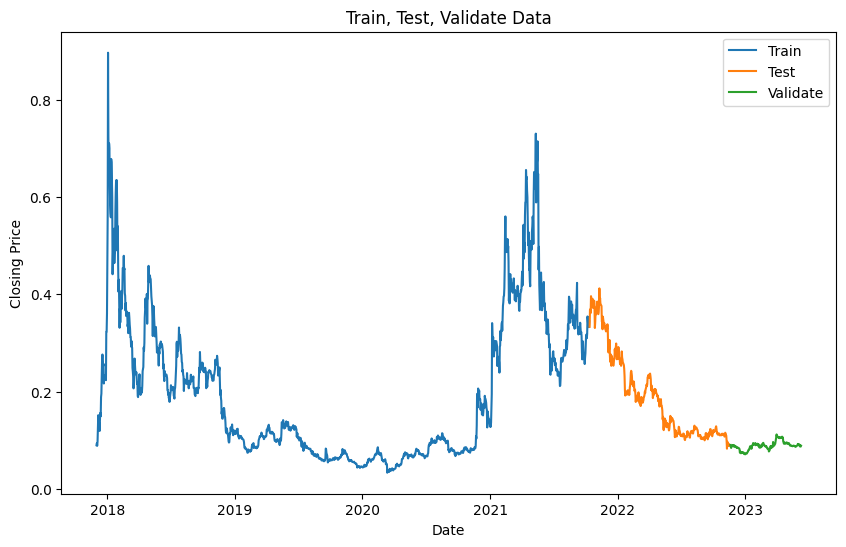

In [77]:
# Vẽ biểu đồ train, test và validate
plt.figure(figsize=(10, 6))
plt.plot(train_dates, train_prices, label='Train')
plt.plot(test_dates, test_prices, label='Test')
plt.plot(validate_dates, validate_prices, label='Validate')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Train, Test, Validate Data')
plt.legend()
plt.show()

In [78]:
# Huấn luyện mô hình Isolation Forest để phát hiện bất thường
model = IsolationForest(contamination=0.05)
model.fit(train_prices.reshape(-1, 1))

IsolationForest(contamination=0.05)

In [79]:
# Dự đoán bất thường trên dữ liệu huấn luyện
train_scores = model.decision_function(train_prices.reshape(-1, 1))

# Dự đoán bất thường trên dữ liệu kiểm tra
test_scores = model.decision_function(test_prices.reshape(-1, 1))

# Dự đoán bất thường trên dữ liệu xác thực
validate_scores = model.decision_function(validate_prices.reshape(-1, 1))

In [80]:
# Phát hiện bất thường trong dữ liệu huấn luyện
train_anomalies = np.where(model.predict(train_prices.reshape(-1, 1)) == -1)

# Phát hiện bất thường trong dữ liệu kiểm tra
test_anomalies = np.where(model.predict(test_prices.reshape(-1, 1)) == -1)

# Phát hiện bất thường trong dữ liệu xác thực
validate_anomalies = np.where(model.predict(validate_prices.reshape(-1, 1)) == -1)

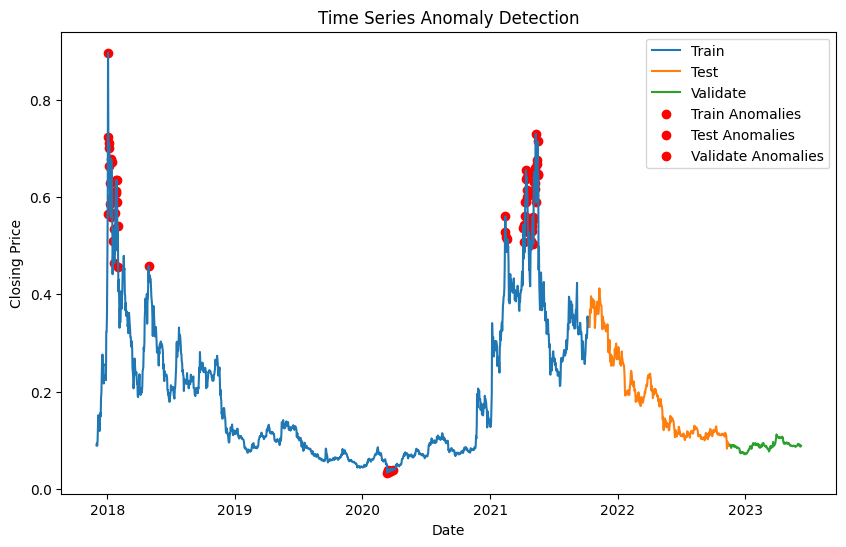

In [81]:
# Vẽ biểu đồ giá đóng cửa và đánh dấu các điểm bất thường
plt.figure(figsize=(10, 6))
plt.plot(train_dates, train_prices, label='Train')
plt.plot(test_dates, test_prices, label='Test')
plt.plot(validate_dates, validate_prices, label='Validate')
plt.scatter(train_dates[train_anomalies], train_prices[train_anomalies], color='red', label='Train Anomalies')
plt.scatter(test_dates[test_anomalies], test_prices[test_anomalies], color='red', label='Test Anomalies')
plt.scatter(validate_dates[validate_anomalies], validate_prices[validate_anomalies], color='red', label='Validate Anomalies')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Time Series Anomaly Detection')
plt.legend()
plt.show()

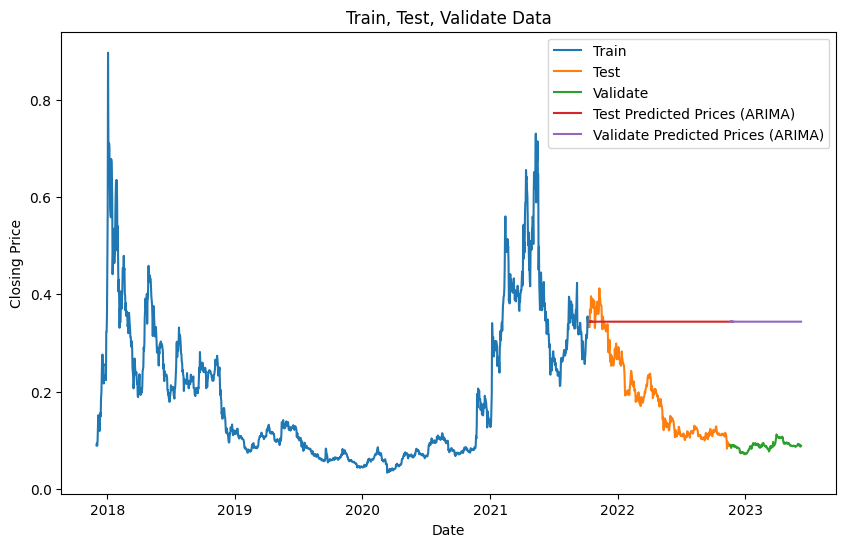

In [82]:
# Dự đoán giá của quá trình testing bằng thuật toán ARIMA
model_arima = auto_arima(train_prices, seasonal=False, trace=False)
test_predicted_prices_arima = model_arima.predict(n_periods=len(test_prices))

# Dự đoán giá của quá trình validation bằng thuật toán ARIMA
validate_predicted_prices_arima = model_arima.predict(n_periods=len(validate_prices))

# Vẽ biểu đồ train, test và validate
plt.figure(figsize=(10, 6))
plt.plot(train_dates, train_prices, label='Train')
plt.plot(test_dates, test_prices, label='Test')
plt.plot(validate_dates, validate_prices, label='Validate')
plt.plot(test_dates, test_predicted_prices_arima, label='Test Predicted Prices (ARIMA)')
plt.plot(validate_dates, validate_predicted_prices_arima, label='Validate Predicted Prices (ARIMA)')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Train, Test, Validate Data')
plt.legend()
plt.show()

In [83]:
# def calculate_metrics(actual, predicted):
#     mape = np.mean(np.abs((actual - predicted) / actual)) * 100
#     mae = np.mean(np.abs(actual - predicted))
#     rmse = np.sqrt(np.mean((actual - predicted)**2))
#     return mape, mae, rmse

# # Calculate metrics for the validation set
# validate_mape, validate_mae, validate_rmse = calculate_metrics(validate_prices, validate_scores)

# # Calculate metrics for the testing set
# test_mape, test_mae, test_rmse = calculate_metrics(test_prices, test_scores)

# print('---------VALIDATE----------')
# print("MAPE:", validate_mape)
# print("MAE:", validate_mae)
# print("RMSE:", validate_rmse)
# print('--------------------------')
# print('---------TEST----------')
# print("MAPE:", test_mape)
# print("MAE:", test_mae)
# print("RMSE:", test_rmse)
# print('-------------------')


In [84]:
def calculate_metrics(actual, predicted):
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    mae = np.mean(np.abs(actual - predicted))
    mse = np.mean((actual - predicted)**2)
    rmse = np.sqrt(mse)
    return mae, mse, rmse

# Calculate metrics for the validation set
validate_mape, validate_mae, validate_rmse = calculate_metrics(validate_prices, validate_scores)

# Calculate metrics for the testing set
test_mape, test_mae, test_rmse = calculate_metrics(test_prices, test_scores)

# In kết quả
print('---------VALIDATE----------')
print("MAPE:", round(validate_mape, 3))
print("MAE:", round(validate_mae, 3))
#print("MSE:", round(validate_mse, 3))
print("RMSE:", round(validate_rmse, 3))
print('--------------------------')
print('---------TEST----------')
print("MAPE:", round(test_mape, 3))
print("MAE:", round(test_mae, 3))
#print("MSE:", round(test_mse, 3))
print("RMSE:", round(test_rmse, 3))
print('-------------------')



---------VALIDATE----------
MAPE: 0.07
MAE: 0.005
RMSE: 0.072
--------------------------
---------TEST----------
MAPE: 0.099
MAE: 0.016
RMSE: 0.128
-------------------


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-6836.142, Time=1.59 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6830.913, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6833.580, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6833.271, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-6832.813, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-6829.355, Time=0.62 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-6830.945, Time=0.69 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-6829.046, Time=0.93 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-6833.061, Time=0.63 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-6831.979, Time=0.16 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-6840.285, Time=1.67 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-6832.581, Time=0.51 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-6838.070, Time=3.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-6833.382, Time=0.48 sec
 ARIMA(0,1,4)(0,0,0

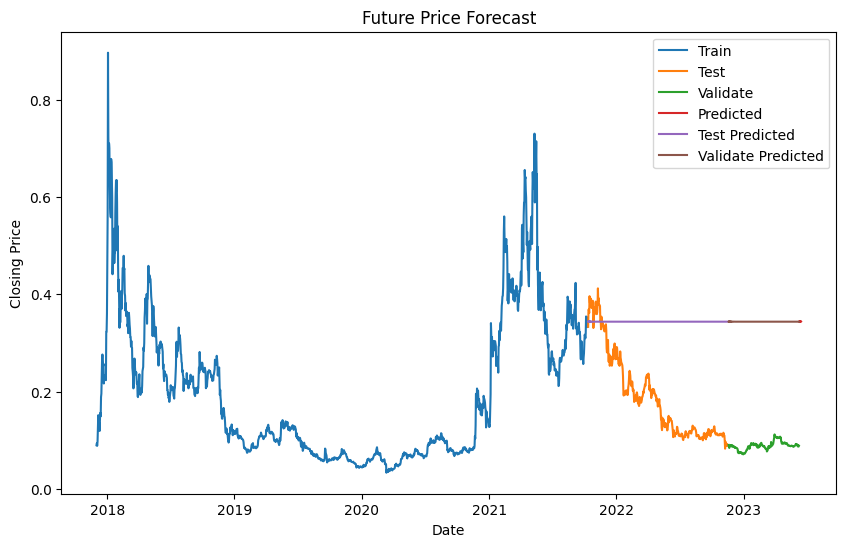

In [85]:
# Huấn luyện mô hình ARIMA trên tập huấn luyện
model = auto_arima(train_prices, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train_prices)

# Dự đoán 7 ngày tiếp theo
future_forecast = model.predict(n_periods=7)

# Tạo các ngày dự đoán cho 7 ngày tiếp theo
future_dates = pd.date_range(start=data['Date'].iloc[-1], periods=7)

# Vẽ biểu đồ dự đoán giá trong tương lai
plt.figure(figsize=(10, 6))
plt.plot(train_dates, train_prices, label='Train')
plt.plot(test_dates, test_prices, label='Test')
plt.plot(validate_dates, validate_prices, label='Validate')
plt.plot(future_dates, future_forecast, label='Predicted')
plt.plot(test_dates, test_predicted_prices_arima, label='Test Predicted')
plt.plot(validate_dates, validate_predicted_prices_arima, label='Validate Predicted')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Future Price Forecast')
plt.legend()
plt.show()

##5:3:2

In [86]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from pmdarima.arima import auto_arima

# Đọc dữ liệu từ file CSV
data = pd.read_csv('/content/XLM-USD.csv')
# Chuyển đổi cột 'date' thành đối tượng datetime
data['Date'] = pd.to_datetime(data['Date'])
# Sắp xếp dữ liệu theo ngày
data = data.sort_values('Date')

In [87]:
# Chia dữ liệu thành tập huấn luyện, tập kiểm tra và tập xác thực
train_size = int(0.5 * len(data))
test_size = int(0.3 * len(data))
validate_size = len(data) - train_size - test_size

train_data = data[:train_size]
test_data = data[train_size:train_size+test_size]
validate_data = data[train_size+test_size:]

In [88]:
# Lấy cột 'date' và 'close' để vẽ biểu đồ
train_dates = train_data['Date'].values
train_prices = train_data['Close'].values

test_dates = test_data['Date'].values
test_prices = test_data['Close'].values

validate_dates = validate_data['Date'].values
validate_prices = validate_data['Close'].values

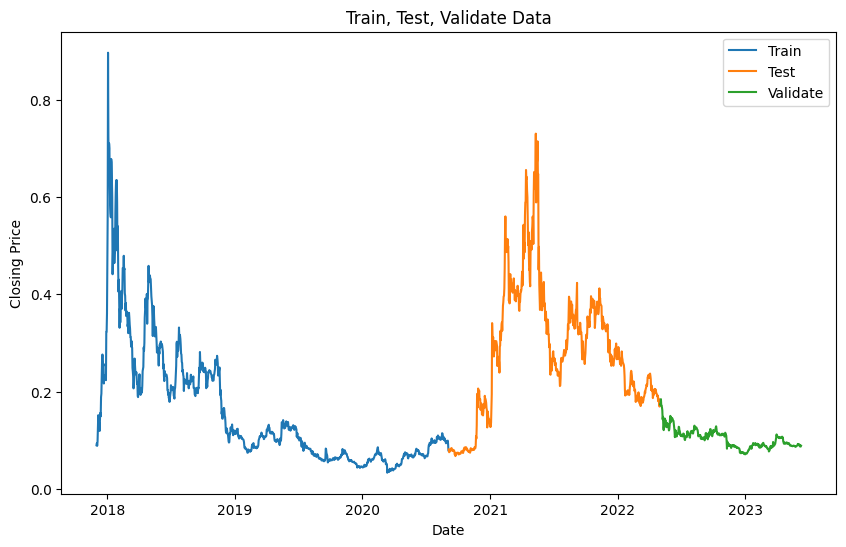

In [89]:
# Vẽ biểu đồ train, test và validate
plt.figure(figsize=(10, 6))
plt.plot(train_dates, train_prices, label='Train')
plt.plot(test_dates, test_prices, label='Test')
plt.plot(validate_dates, validate_prices, label='Validate')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Train, Test, Validate Data')
plt.legend()
plt.show()

In [90]:
# Huấn luyện mô hình Isolation Forest để phát hiện bất thường
model = IsolationForest(contamination=0.05)
model.fit(train_prices.reshape(-1, 1))

IsolationForest(contamination=0.05)

In [91]:
# Dự đoán bất thường trên dữ liệu huấn luyện
train_scores = model.decision_function(train_prices.reshape(-1, 1))

# Dự đoán bất thường trên dữ liệu kiểm tra
test_scores = model.decision_function(test_prices.reshape(-1, 1))

# Dự đoán bất thường trên dữ liệu xác thực
validate_scores = model.decision_function(validate_prices.reshape(-1, 1))

In [92]:
# Phát hiện bất thường trong dữ liệu huấn luyện
train_anomalies = np.where(model.predict(train_prices.reshape(-1, 1)) == -1)

# Phát hiện bất thường trong dữ liệu kiểm tra
test_anomalies = np.where(model.predict(test_prices.reshape(-1, 1)) == -1)

# Phát hiện bất thường trong dữ liệu xác thực
validate_anomalies = np.where(model.predict(validate_prices.reshape(-1, 1)) == -1)

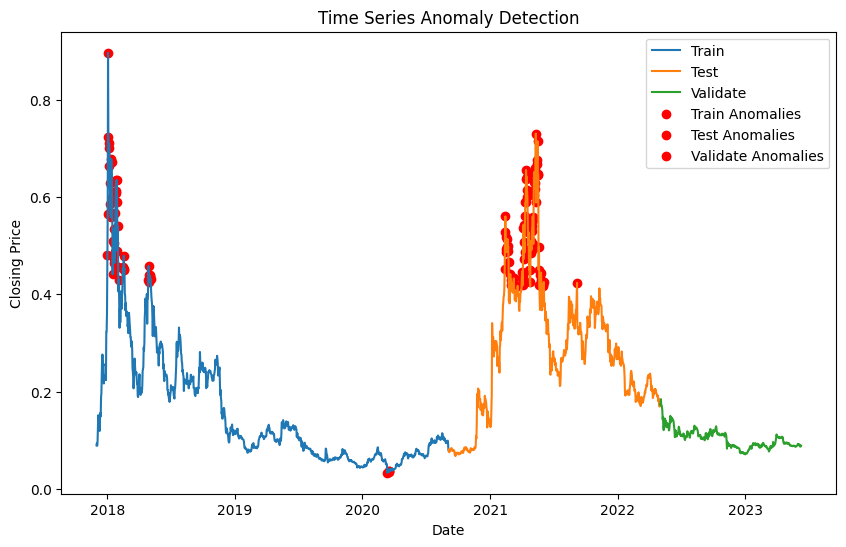

In [93]:
# Vẽ biểu đồ giá đóng cửa và đánh dấu các điểm bất thường
plt.figure(figsize=(10, 6))
plt.plot(train_dates, train_prices, label='Train')
plt.plot(test_dates, test_prices, label='Test')
plt.plot(validate_dates, validate_prices, label='Validate')
plt.scatter(train_dates[train_anomalies], train_prices[train_anomalies], color='red', label='Train Anomalies')
plt.scatter(test_dates[test_anomalies], test_prices[test_anomalies], color='red', label='Test Anomalies')
plt.scatter(validate_dates[validate_anomalies], validate_prices[validate_anomalies], color='red', label='Validate Anomalies')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Time Series Anomaly Detection')
plt.legend()
plt.show()

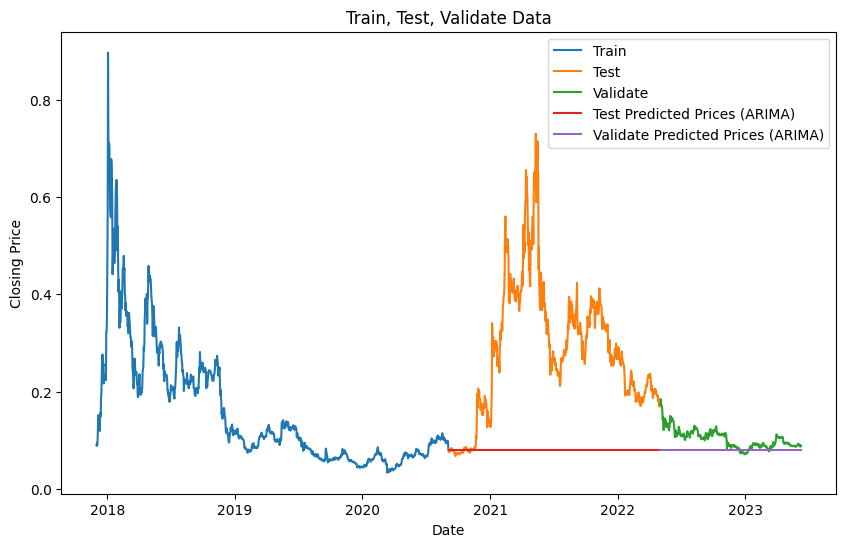

In [94]:
# Dự đoán giá của quá trình testing bằng thuật toán ARIMA
model_arima = auto_arima(train_prices, seasonal=False, trace=False)
test_predicted_prices_arima = model_arima.predict(n_periods=len(test_prices))

# Dự đoán giá của quá trình validation bằng thuật toán ARIMA
validate_predicted_prices_arima = model_arima.predict(n_periods=len(validate_prices))

# Vẽ biểu đồ train, test và validate
plt.figure(figsize=(10, 6))
plt.plot(train_dates, train_prices, label='Train')
plt.plot(test_dates, test_prices, label='Test')
plt.plot(validate_dates, validate_prices, label='Validate')
plt.plot(test_dates, test_predicted_prices_arima, label='Test Predicted Prices (ARIMA)')
plt.plot(validate_dates, validate_predicted_prices_arima, label='Validate Predicted Prices (ARIMA)')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Train, Test, Validate Data')
plt.legend()
plt.show()

In [95]:
# def calculate_metrics(actual, predicted):
#     mape = np.mean(np.abs((actual - predicted) / actual)) * 100
#     mae = np.mean(np.abs(actual - predicted))
#     rmse = np.sqrt(np.mean((actual - predicted)**2))
#     return mape, mae, rmse

# # Calculate metrics for the validation set
# validate_mape, validate_mae, validate_rmse = calculate_metrics(validate_prices, validate_scores)

# # Calculate metrics for the testing set
# test_mape, test_mae, test_rmse = calculate_metrics(test_prices, test_scores)

# print('---------VALIDATE----------')
# print("MAPE:", validate_mape)
# print("MAE:", validate_mae)
# print("RMSE:", validate_rmse)
# print('--------------------------')
# print('---------TEST----------')
# print("MAPE:", test_mape)
# print("MAE:", test_mae)
# print("RMSE:", test_rmse)
# print('-------------------')


In [96]:
def calculate_metrics(actual, predicted):
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    mae = np.mean(np.abs(actual - predicted))
    mse = np.mean((actual - predicted)**2)
    rmse = np.sqrt(mse)
    return mae, mse, rmse

# Calculate metrics for the validation set
validate_mape, validate_mae, validate_rmse = calculate_metrics(validate_prices, validate_scores)

# Calculate metrics for the testing set
test_mape, test_mae, test_rmse = calculate_metrics(test_prices, test_scores)

# In kết quả
print('---------VALIDATE----------')
print("MAPE:", round(validate_mape, 3))
print("MAE:", round(validate_mae, 3))
#print("MSE:", round(validate_mse, 3))
print("RMSE:", round(validate_rmse, 3))
print('--------------------------')
print('---------TEST----------')
print("MAPE:", round(test_mape, 3))
print("MAE:", round(test_mae, 3))
#print("MSE:", round(test_mse, 3))
print("RMSE:", round(test_rmse, 3))
print('-------------------')



---------VALIDATE----------
MAPE: 0.064
MAE: 0.004
RMSE: 0.067
--------------------------
---------TEST----------
MAPE: 0.238
MAE: 0.087
RMSE: 0.295
-------------------


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-5086.695, Time=0.62 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5090.100, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5088.997, Time=0.25 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5088.932, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5092.100, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5086.102, Time=0.47 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.862 seconds


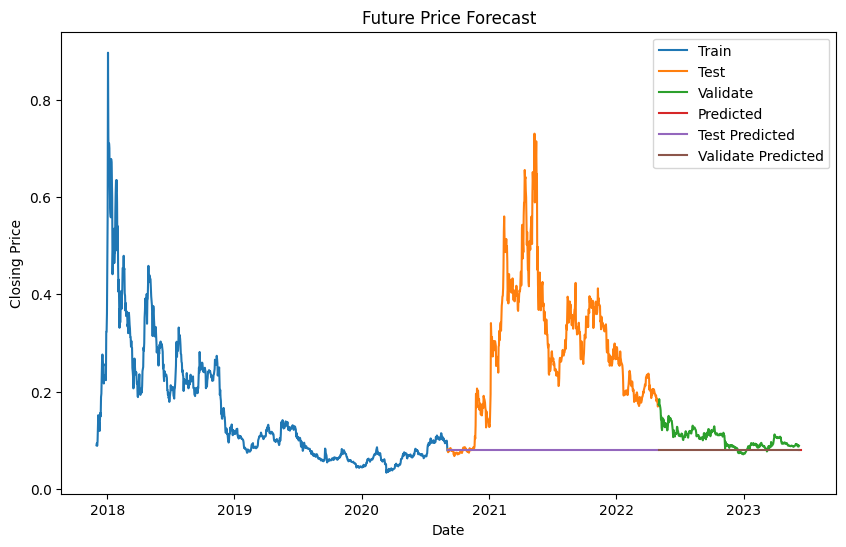

In [97]:
# Huấn luyện mô hình ARIMA trên tập huấn luyện
model = auto_arima(train_prices, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train_prices)

# Dự đoán 7 ngày tiếp theo
future_forecast = model.predict(n_periods=7)

# Tạo các ngày dự đoán cho 7 ngày tiếp theo
future_dates = pd.date_range(start=data['Date'].iloc[-1], periods=7)

# Vẽ biểu đồ dự đoán giá trong tương lai
plt.figure(figsize=(10, 6))
plt.plot(train_dates, train_prices, label='Train')
plt.plot(test_dates, test_prices, label='Test')
plt.plot(validate_dates, validate_prices, label='Validate')
plt.plot(future_dates, future_forecast, label='Predicted')
plt.plot(test_dates, test_predicted_prices_arima, label='Test Predicted')
plt.plot(validate_dates, validate_predicted_prices_arima, label='Validate Predicted')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Future Price Forecast')
plt.legend()
plt.show()

##6:2:2

In [98]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from pmdarima.arima import auto_arima

# Đọc dữ liệu từ file CSV
data = pd.read_csv('/content/XLM-USD.csv')
# Chuyển đổi cột 'date' thành đối tượng datetime
data['Date'] = pd.to_datetime(data['Date'])
# Sắp xếp dữ liệu theo ngày
data = data.sort_values('Date')

In [99]:
# Chia dữ liệu thành tập huấn luyện, tập kiểm tra và tập xác thực
train_size = int(0.6 * len(data))
test_size = int(0.2 * len(data))
validate_size = len(data) - train_size - test_size

train_data = data[:train_size]
test_data = data[train_size:train_size+test_size]
validate_data = data[train_size+test_size:]

In [100]:
# Lấy cột 'date' và 'close' để vẽ biểu đồ
train_dates = train_data['Date'].values
train_prices = train_data['Close'].values

test_dates = test_data['Date'].values
test_prices = test_data['Close'].values

validate_dates = validate_data['Date'].values
validate_prices = validate_data['Close'].values

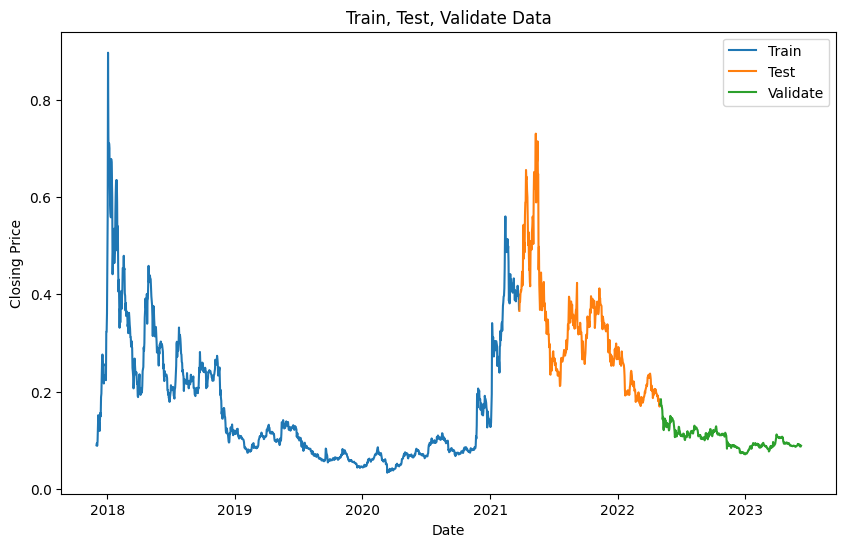

In [101]:
# Vẽ biểu đồ train, test và validate
plt.figure(figsize=(10, 6))
plt.plot(train_dates, train_prices, label='Train')
plt.plot(test_dates, test_prices, label='Test')
plt.plot(validate_dates, validate_prices, label='Validate')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Train, Test, Validate Data')
plt.legend()
plt.show()

In [102]:
# Huấn luyện mô hình Isolation Forest để phát hiện bất thường
model = IsolationForest(contamination=0.05)
model.fit(train_prices.reshape(-1, 1))

IsolationForest(contamination=0.05)

In [103]:
# Dự đoán bất thường trên dữ liệu huấn luyện
train_scores = model.decision_function(train_prices.reshape(-1, 1))

# Dự đoán bất thường trên dữ liệu kiểm tra
test_scores = model.decision_function(test_prices.reshape(-1, 1))

# Dự đoán bất thường trên dữ liệu xác thực
validate_scores = model.decision_function(validate_prices.reshape(-1, 1))

In [104]:
# Phát hiện bất thường trong dữ liệu huấn luyện
train_anomalies = np.where(model.predict(train_prices.reshape(-1, 1)) == -1)

# Phát hiện bất thường trong dữ liệu kiểm tra
test_anomalies = np.where(model.predict(test_prices.reshape(-1, 1)) == -1)

# Phát hiện bất thường trong dữ liệu xác thực
validate_anomalies = np.where(model.predict(validate_prices.reshape(-1, 1)) == -1)

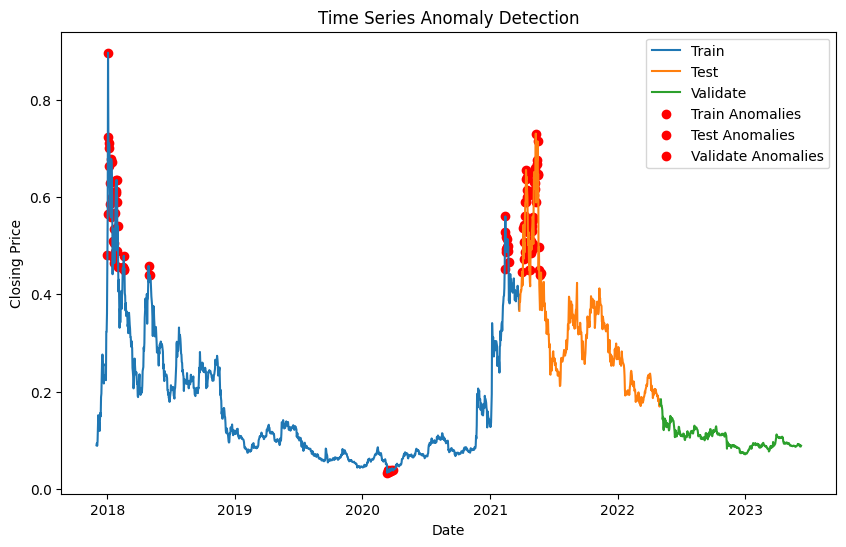

In [105]:
# Vẽ biểu đồ giá đóng cửa và đánh dấu các điểm bất thường
plt.figure(figsize=(10, 6))
plt.plot(train_dates, train_prices, label='Train')
plt.plot(test_dates, test_prices, label='Test')
plt.plot(validate_dates, validate_prices, label='Validate')
plt.scatter(train_dates[train_anomalies], train_prices[train_anomalies], color='red', label='Train Anomalies')
plt.scatter(test_dates[test_anomalies], test_prices[test_anomalies], color='red', label='Test Anomalies')
plt.scatter(validate_dates[validate_anomalies], validate_prices[validate_anomalies], color='red', label='Validate Anomalies')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Time Series Anomaly Detection')
plt.legend()
plt.show()

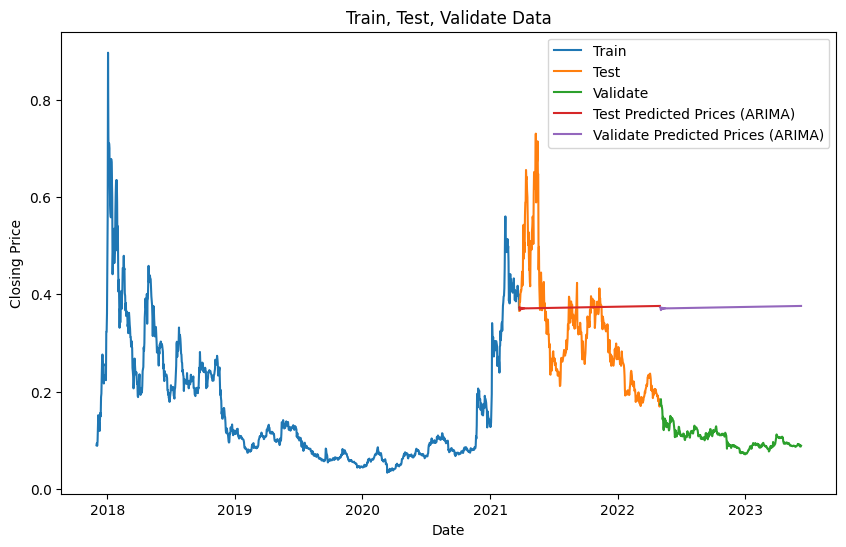

In [106]:
# Dự đoán giá của quá trình testing bằng thuật toán ARIMA
model_arima = auto_arima(train_prices, seasonal=False, trace=False)
test_predicted_prices_arima = model_arima.predict(n_periods=len(test_prices))

# Dự đoán giá của quá trình validation bằng thuật toán ARIMA
validate_predicted_prices_arima = model_arima.predict(n_periods=len(validate_prices))

# Vẽ biểu đồ train, test và validate
plt.figure(figsize=(10, 6))
plt.plot(train_dates, train_prices, label='Train')
plt.plot(test_dates, test_prices, label='Test')
plt.plot(validate_dates, validate_prices, label='Validate')
plt.plot(test_dates, test_predicted_prices_arima, label='Test Predicted Prices (ARIMA)')
plt.plot(validate_dates, validate_predicted_prices_arima, label='Validate Predicted Prices (ARIMA)')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Train, Test, Validate Data')
plt.legend()
plt.show()

In [107]:
# def calculate_metrics(actual, predicted):
#     mape = np.mean(np.abs((actual - predicted) / actual)) * 100
#     mae = np.mean(np.abs(actual - predicted))
#     rmse = np.sqrt(np.mean((actual - predicted)**2))
#     return mape, mae, rmse

# # Calculate metrics for the validation set
# validate_mape, validate_mae, validate_rmse = calculate_metrics(validate_prices, validate_scores)

# # Calculate metrics for the testing set
# test_mape, test_mae, test_rmse = calculate_metrics(test_prices, test_scores)

# print('---------VALIDATE----------')
# print("MAPE:", validate_mape)
# print("MAE:", validate_mae)
# print("RMSE:", validate_rmse)
# print('--------------------------')
# print('---------TEST----------')
# print("MAPE:", test_mape)
# print("MAE:", test_mae)
# print("RMSE:", test_rmse)
# print('-------------------')


In [108]:
def calculate_metrics(actual, predicted):
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    mae = np.mean(np.abs(actual - predicted))
    mse = np.mean((actual - predicted)**2)
    rmse = np.sqrt(mse)
    return mae, mse, rmse

# Calculate metrics for the validation set
validate_mape, validate_mae, validate_rmse = calculate_metrics(validate_prices, validate_scores)

# Calculate metrics for the testing set
test_mape, test_mae, test_rmse = calculate_metrics(test_prices, test_scores)

# In kết quả
print('---------VALIDATE----------')
print("MAPE:", round(validate_mape, 3))
print("MAE:", round(validate_mae, 3))
#print("MSE:", round(validate_mse, 3))
print("RMSE:", round(validate_rmse, 3))
print('--------------------------')
print('---------TEST----------')
print("MAPE:", round(test_mape, 3))
print("MAE:", round(test_mae, 3))
#print("MSE:", round(test_mse, 3))
print("RMSE:", round(test_rmse, 3))
print('-------------------')



---------VALIDATE----------
MAPE: 0.042
MAE: 0.002
RMSE: 0.049
--------------------------
---------TEST----------
MAPE: 0.267
MAE: 0.101
RMSE: 0.318
-------------------


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-6109.432, Time=2.03 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6106.605, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6105.255, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6105.202, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-6108.433, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-6109.952, Time=1.16 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-6105.167, Time=0.33 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-6102.840, Time=0.64 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-6117.807, Time=0.93 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-6106.871, Time=0.66 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-6123.518, Time=1.01 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-6124.263, Time=1.92 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-6114.801, Time=0.49 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=-6108.010, Time=1.65 sec
 ARIMA(3,1,4)(0,0,0

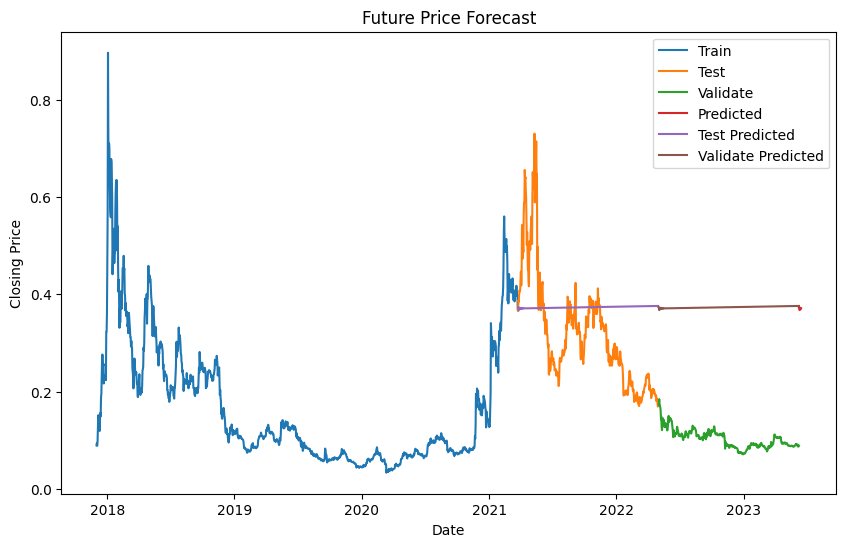

In [109]:
# Huấn luyện mô hình ARIMA trên tập huấn luyện
model = auto_arima(train_prices, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train_prices)

# Dự đoán 7 ngày tiếp theo
future_forecast = model.predict(n_periods=7)

# Tạo các ngày dự đoán cho 7 ngày tiếp theo
future_dates = pd.date_range(start=data['Date'].iloc[-1], periods=7)

# Vẽ biểu đồ dự đoán giá trong tương lai
plt.figure(figsize=(10, 6))
plt.plot(train_dates, train_prices, label='Train')
plt.plot(test_dates, test_prices, label='Test')
plt.plot(validate_dates, validate_prices, label='Validate')
plt.plot(future_dates, future_forecast, label='Predicted')
plt.plot(test_dates, test_predicted_prices_arima, label='Test Predicted')
plt.plot(validate_dates, validate_predicted_prices_arima, label='Validate Predicted')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Future Price Forecast')
plt.legend()
plt.show()